# DefWeb : Variational AutoEncoder(VAE)

#### Description:
#### - In this Code, we implement our VAE to obfuscate Website Fingerprints(WFs)
#### - We create 100-dimensional latent space for 100 website cluster (2-dimensional latent space for 2 website cluster)
#### - Input: Preprocessed WFs
#### - Output: Reconstructed WFs



In [383]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"

import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv1D, Conv1DTranspose,  Flatten, Dense, Lambda, MaxPooling1D, BatchNormalization, Dropout, Activation, UpSampling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tensorflow import keras

from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


K.clear_session()
#np.random.seed(237)

# Input Data

In [384]:
train_X = pd.read_csv('Chrome/trainX_2_US_Chrome.csv', header=None)
train_Y = pd.read_csv('Chrome/trainY_2_US_Chrome.csv', header=None)

#train_X = pd.read_csv('Chrome/trainX_100_US_Chrome.csv', header=None)
#train_Y = pd.read_csv('Chrome/trainY_100_US_Chrome.csv', header=None)

In [385]:
trainX = train_X.to_numpy()
trainY = train_Y.to_numpy()

In [386]:
print(trainX.shape)

(200, 6000)


# Shuffled 
### In this portion, we shuffled within the website clusters to make sure the VAE model learn efficiently

In [387]:
website_num=2
#website_num=100

In [388]:
websites_test = [trainX[i:i + 100] for i in range(0, len(trainX), 100)]
websites_test=np.asarray(websites_test)

In [389]:
#websites_test[0][0:5]

In [390]:
web_num =0
for web_num in range (0,website_num):
       np.random.shuffle(websites_test[web_num])
#random.shuffle(websites_test[0])

In [391]:
websites_shuffled=np.reshape(websites_test,(website_num*100,6000))

In [392]:
#print(websites_shuffled-trainX)

In [393]:
trainX = np.expand_dims(trainX,axis=2)

In [394]:
print(trainX.shape, trainY.shape)
#print(train_X.shape)

(200, 6000, 1) (200, 1)


In [395]:
websites_shuffled = np.expand_dims(websites_shuffled,axis=2)

In [396]:
#print(websites_shuffled, websites_shuffled.shape)

# Normalized
### In this portion, we normalized WF Dataset.

In [397]:

minimum = np.amin(trainX)
maximum = np.amax(trainX)

trainX_normalized = (trainX-minimum)/(maximum-minimum)
#trainX_normalized = trainX

print(trainX_normalized.shape)



trainX_test = trainX_normalized


(200, 6000, 1)


In [398]:
print(trainX_test.max(),trainX_test.min())

1.0 0.0


In [399]:

minimum_s = np.amin(websites_shuffled)
maximum_s = np.amax(websites_shuffled)

Shuffled_train_normalized = (websites_shuffled-minimum_s)/(maximum_s-minimum_s)
#trainX_normalized = trainX

print(Shuffled_train_normalized.shape)



trainX_Shuffled = Shuffled_train_normalized


(200, 6000, 1)


In [400]:
print(trainX_Shuffled.max(),trainX_Shuffled.min())

1.0 0.0


In [401]:
#print(trainX_test)

In [402]:
#print(trainX_test[0:2,:])
print(trainY[0:10000,0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#### This portion is for Website 100 to visually see the WFs (Skip for website 2)

In [403]:
'''
fig = plt.figure(figsize=(35,5))

websites_name = ['360', '9gag', 'abs-cbn', 'adobe', 'airbnb', 'aliexpress', 'allegro', 'amazon', 'apple', 'archive',
                 'baidu', 'bbc', 'bing', 'booking', 'bukalapak', 'canva', 'chase', 'craigslist','csdn', 'dailymail',
                 'dailymotion', 'digikala', 'discord', 'dropbox', 'ebay', 'espn', 'espncricinfo', 'etsy', 'exoclick', 'flipkart',
                 'force', 'foxnews', 'github', 'globo', 'godaddy', 'goodreads', 'google', 'healthline', 'hulu', 'ikea',
                 'imdb', 'imgur', 'indeed','intuit', 'jd', 'kompas', 'linkedin', 'liputan6', 'live', 'mail',
                 'mediafire', 'medium', 'mozila', 'msn', 'naver', 'netflix', 'nih', 'nordstrom', 'office', 'okezone',
                 'oracle','paypal', 'pinterest', 'popads', 'qq', 'quora', 'reddit', 'researchgate', 'scribd','slideshare',
                 'sohu', 'soundcloud', 'spotify', 'stackexchange', 'stackoverflow','steamcommunity', 'steampowered', 'taobao', 'theguardian', 'thesaurus',
                 'tistory', 'tmall', 'tribunnews', 'tripadvisor', 'tumblr', 'twitch', 'vimeo', 'walmart', 'weather','weibo',
                 'wellsfargo', 'wikipedia', 'yahoo', 'yandex', 'yelp', 'youtube', 'yy', 'zhanqi', 'zillow', 'zoom']

num_websites = 100

plt.plot(trainX[100],label= websites_name[1])
plt.legend()
plt.xticks(np.arange(0, 6500, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
plt.show()

'''

'\nfig = plt.figure(figsize=(35,5))\n\nwebsites_name = [\'360\', \'9gag\', \'abs-cbn\', \'adobe\', \'airbnb\', \'aliexpress\', \'allegro\', \'amazon\', \'apple\', \'archive\',\n                 \'baidu\', \'bbc\', \'bing\', \'booking\', \'bukalapak\', \'canva\', \'chase\', \'craigslist\',\'csdn\', \'dailymail\',\n                 \'dailymotion\', \'digikala\', \'discord\', \'dropbox\', \'ebay\', \'espn\', \'espncricinfo\', \'etsy\', \'exoclick\', \'flipkart\',\n                 \'force\', \'foxnews\', \'github\', \'globo\', \'godaddy\', \'goodreads\', \'google\', \'healthline\', \'hulu\', \'ikea\',\n                 \'imdb\', \'imgur\', \'indeed\',\'intuit\', \'jd\', \'kompas\', \'linkedin\', \'liputan6\', \'live\', \'mail\',\n                 \'mediafire\', \'medium\', \'mozila\', \'msn\', \'naver\', \'netflix\', \'nih\', \'nordstrom\', \'office\', \'okezone\',\n                 \'oracle\',\'paypal\', \'pinterest\', \'popads\', \'qq\', \'quora\', \'reddit\', \'researchgate\', \'scribd

Text(0, 0.5, 'PnP timing')

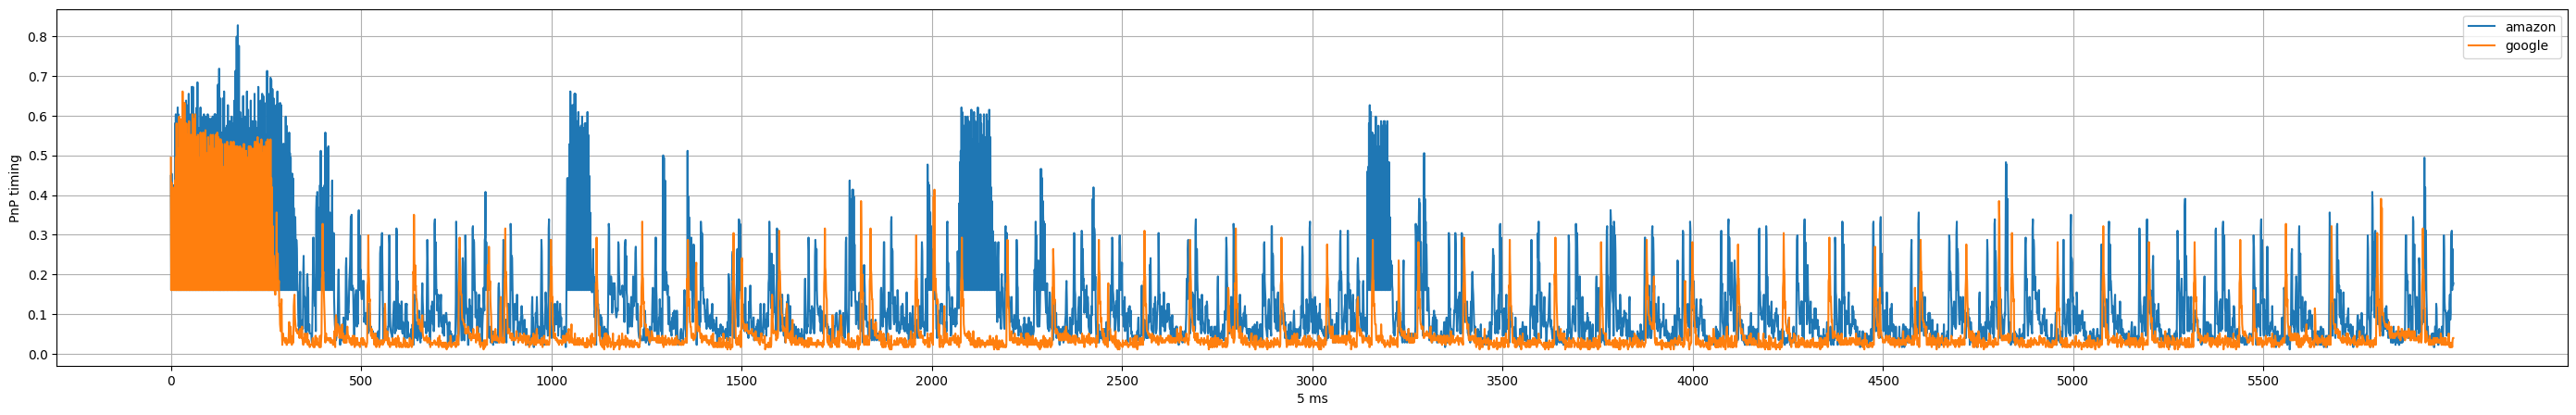

In [404]:
fig = plt.figure(figsize=(35,5))

#First Website Cluster: Amazon.com
plt.plot(trainX_Shuffled[0],label='amazon')

#Second Website Cluster: Google.com
plt.plot(trainX_Shuffled[100],label='google')

plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")

#fig.savefig('Graph_Amaozon_Google.png')
#plt.show()

In [405]:
# encoding dimension; i.e. dimensionality of the latent space
latent_dim = 2

# VAE (Encoder) 

In [406]:

inputs_shape = (6000,1)

# Encoder architecture: Input -> Conv1D*4 -> Flatten -> Dense
encoder_inputs = Input(shape=inputs_shape)
#x = layers.Conv1D(64, 1, activation="relu", padding="same")(encoder_inputs)
#x = layers.Conv1D(32, 1, activation="relu", padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
#x = MaxPooling1D(pool_size=4)(x)
x = layers.Conv1D(128, 3, activation="relu", padding="same")(x)
#x = MaxPooling1D(pool_size=4)(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
#x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

print(z_mean.shape, z_log_var.shape)
#z = Sampling()([z_mean, z_log_var])

# sample vector from the latent distribution
z = Lambda(sampling)([z_mean, z_log_var])


encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(None, 2) (None, 2)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 6000, 32)             128       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 6000, 64)             6208      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 6000, 128)            24704     ['conv1d_1[0][0]']            
                                                                        

# VAE(Decoder)

In [407]:
# decoder takes the latent distribution sample as input
print(K.int_shape(z)[1:])
decoder_input = Input(K.int_shape(z)[1:])
#decoder_input = Input(shape=(latent_dim,))

x = Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)
print(x.shape)
# use Conv1DTranspose to reverse the conv layers from the encoder

'''
x = Conv1DTranspose(32, 8, padding='same', activation='relu',strides =2)(x)
x = Conv1DTranspose(64, 8, padding='same', activation='relu',strides =3)(x)
x = Conv1DTranspose(128, 16, padding='same', activation='relu', strides=2)(x)
x = Conv1DTranspose(256, 16, padding='same', activation='relu', strides=2)(x)
'''
x = Conv1DTranspose(128, 3, padding='same', activation='relu')(x)
#x = UpSampling1D(size=4)(x)
x = Conv1DTranspose(64, 3, padding='same', activation='relu')(x)
#x = UpSampling1D(size=4)(x)
x = Conv1DTranspose(32, 3, padding='same', activation='relu')(x)

x = Conv1D(1, 1, padding='same', activation='sigmoid')(x)


#Original
#x = Conv1DTranspose(64, 1, padding='same', activation='relu')(x)
#x = Conv1D(1, 1, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)
z_decoder = decoder(z)
decoder.summary()

(2,)
(None, 6000, 128)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 768000)            2304000   
                                                                 
 reshape (Reshape)           (None, 6000, 128)         0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 6000, 128)         49280     
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 6000, 64)          24640     
 Transpose)                                                      
                                                                 
 conv1d_transpose_2 (Conv1D  (None, 60

In [408]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis =(1))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=0))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [409]:
batchSize = 2

In [410]:
vae = VAE(encoder, decoder)
print(vae)
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='reconstruction_loss', min_delta=0, patience=10, verbose=5, mode='auto')
###########
#print(X_train.shape)
#print(trainX_test.shape)
#print(trainX_Shuffled.shape)
###########

#For 2 websites 
vae.fit(trainX_Shuffled, epochs=300,batch_size=batchSize)

#For 100 websites
#vae.fit(trainX_Shuffled, epochs=300, batch_size=batchSize)

Epoch 1/300
100/100 [==============================] - 19s 108ms/step - loss: 2393.7545 - reconstruction_loss: 1855.8353 - kl_loss: 31.9688
Epoch 2/300
100/100 [==============================] - 11s 105ms/step - loss: 1599.7480 - reconstruction_loss: 1627.0591 - kl_loss: 3.2694
Epoch 3/300
100/100 [==============================] - 10s 100ms/step - loss: 1599.1495 - reconstruction_loss: 1618.6481 - kl_loss: 2.6674
Epoch 4/300
100/100 [==============================] - 11s 106ms/step - loss: 1642.1038 - reconstruction_loss: 1613.6246 - kl_loss: 2.6688
Epoch 5/300
100/100 [==============================] - 10s 102ms/step - loss: 1604.5302 - reconstruction_loss: 1610.5133 - kl_loss: 2.5499
Epoch 6/300
100/100 [==============================] - 10s 103ms/step - loss: 1642.6151 - reconstruction_loss: 1607.2407 - kl_loss: 2.6953
Epoch 7/300
100/100 [==============================] - 7s 67ms/step - loss: 1569.4533 - reconstruction_loss: 1605.0741 - kl_loss: 2.8929
Epoch 8/300
100/100 [=======

# Model Save and Load

## Model save

In [411]:
#VAE.save("/Research/WebsiteFingerPrinting/Generated_Data_100/VAE_100D_Aug30.h5")
#vae.encoder.save('VAE_encoder.h5')
#vae.decoder.save('VAE_decoder.h5')

## Model Load

In [412]:
#encoder = tf.keras.models.load_model('VAE_encoder_100_6000_100D_Sep27_NewLayers_FF.h5')
#decoder = tf.keras.models.load_model('VAE_decoder_100_6000_100D_Sep27_NewLayser_FF.h5')

# Plotting the Latent space (After the Encoder)

In [413]:
# Translate into the latent space
encoder = Model(encoder_inputs, z_mean)

print("-----")
print(z_mean.shape)

print("-----")
print(encoder_inputs.shape)
print(trainX_test.shape)

-----
(None, 2)
-----
(None, 6000, 1)
(200, 6000, 1)


100/100 [==============================] - 1s 6ms/step
-----
(200, 2)
-----
(200, 1)


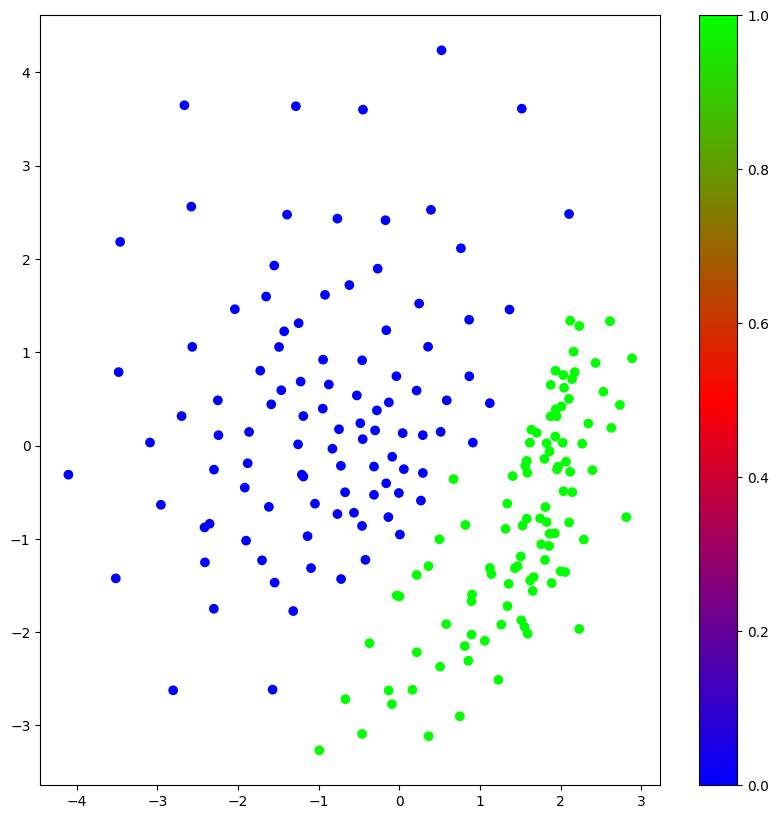

In [414]:
X_valid_encoded_ori = encoder.predict(trainX_test, batch_size=batchSize)
print("-----")
print(X_valid_encoded_ori.shape)
#print(X_valid_encoded_ori)

print("-----")
print(trainY.shape)
#print(trainY)

plt.figure(figsize=(10, 10))
plt.scatter(X_valid_encoded_ori[:, 0], X_valid_encoded_ori[:, 1],c=trainY, cmap='brg')
plt.colorbar()
plt.savefig('Latentspace2d_Amazon_Google.png')
#plt.show()

In [415]:
'''
with open('Latent_space.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(X_valid_encoded_ori)
'''

"\nwith open('Latent_space.csv', 'w', newline='') as file:\n    mywriter = csv.writer(file, delimiter=',')\n    mywriter.writerows(X_valid_encoded_ori)\n"

# Plotting the modified Latent space (After the Encoder)

In [416]:
# Translate into the latent space
Encoder_spread = Model(encoder_inputs, z_mean)

print("-----")
print(z_mean)
print("-----")
#print(encoder_inputs.shape)
#print(trainX_test.shape)


-----
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='z_mean/BiasAdd:0', description="created by layer 'z_mean'")
-----


100/100 [==============================] - 1s 6ms/step
-----
----------------------------------------------------------------
mean
(2, 2)
----------------------------------------------------------------
(2, 2, 2)
----------------------------------------------------------------
(2, 2, 2)
Dis_ex_each
(2, 100, 2)
----------------------------------------------------------------
----------------------------------------------------------------
Website_Noise_each_web and spead
(2, 100, 2)
----------------------------------------------------------------
Website_Noise_each_web
(200, 2)
----------------------------------------------------------------


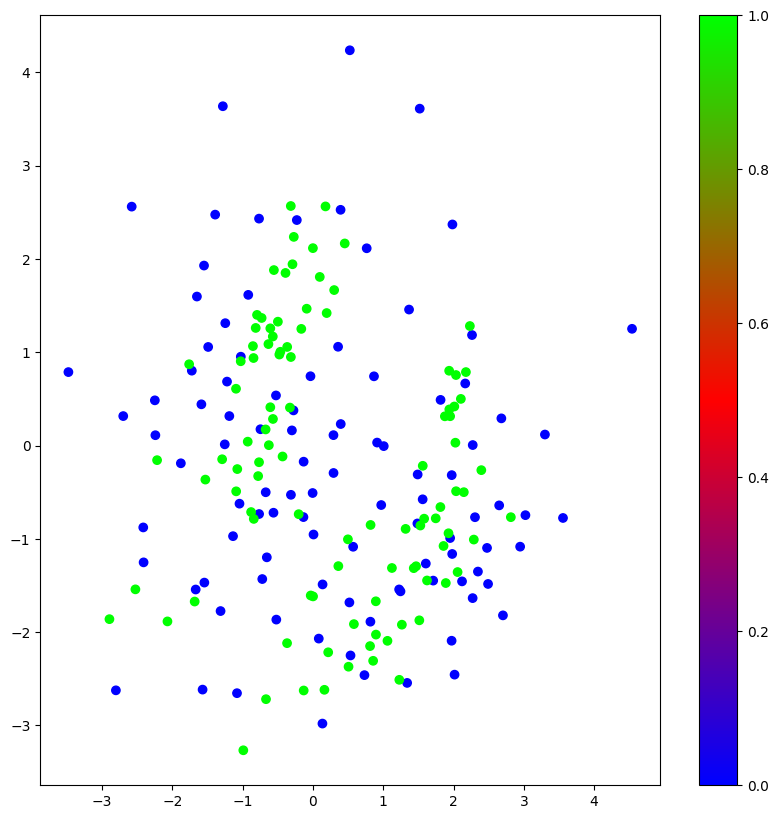

In [417]:

X_valid_encoded_new = Encoder_spread.predict(trainX_test, batch_size=batchSize)
print("-----")

#Seperating Website Clusters based on the original WF dataset
step = 100
#This can be changed based on the number of Websites
Num_websites = 2
measurement = 100

websites = [X_valid_encoded_new[i:i + step] for i in range(0, len(X_valid_encoded_new), step)]
websites = np.asarray(websites)

print('----------------------------------------------------------------')

#Step 1 
#Each Mean point of the Website's Cluster 
mean = [np.mean(websites[i,:],axis=0) for i in range(0, Num_websites)]
mean = np.asarray(mean)
print('mean')
print(mean.shape)
#print(mean[0,:])

'''
#Extra experiments
print('----------------------------------------------------------------')
#Total Mean in the Latent Space
total_mean = 0
for i in range (0,Num_websites):
    total_mean += np.mean(websites[i,:],axis=0)
    
total_mean= total_mean/Num_websites

print('total mean')
print(total_mean.shape)
#print(total_mean)

print('----------------------------------------------------------------')
#Distance from Total mean 
Distance = np.ones((Num_websites,latent_dim))
for i in range (0,Num_websites):
    Distance[i,:] = total_mean - mean[i,:]
    
print('Distance')
print(Distance.shape)

print('Max & min Distance')
#print(Distance.max())
#print(Distance.min())

Dis_ex = np.ones((Num_websites,measurement,latent_dim))

for i in range (0, Num_websites):
    for k in range (0, measurement):
        Dis_ex[i,k,:] = Distance[i]

print('Dis_ex')
#print(Dis_ex.shape)
#print(Dis_ex[0].shape)

print('----------------------------------------------------------------')


#Merge clusters based on the Mean value of Total cluster
Website_Noise_mean =  websites + Dis_ex
print('Actual Spreading part----------------------------------------------------------------')


'''
#Step 2
#Calculating the distance between each website
print('----------------------------------------------------------------')
dist = np.ones((Num_websites,Num_websites,latent_dim))
print (dist.shape)

for i in range (0,Num_websites):
    for k in range (0,Num_websites):
        dist[i,k,:] = mean[i,:] - mean[k,:]
        
#Step 3 
# expanded to 100 measurements since we have 100 measurements of each website
Dis_ex_each = np.zeros((Num_websites,measurement,latent_dim))
print('----------------------------------------------------------------')
for i in range (0,100,Num_websites):
    Dis_ex_each [:,0+i:Num_websites+i,:] = dist

print(dist.shape)
print('Dis_ex_each')
print(Dis_ex_each.shape)
print('----------------------------------------------------------------')

#Step 4
#Spread separate clusters based on the mean value of each website cluster
Website_Noise_each_web = websites - Dis_ex_each

print('----------------------------------------------------------------')    
print('Website_Noise_each_web and spead')
print(Website_Noise_each_web.shape)
print('----------------------------------------------------------------')

# Reshaping
#Website_Noise_mean=np.reshape(Website_Noise_mean,(Num_websites*measurement,latent_dim))
Website_Noise_each_web=np.reshape(Website_Noise_each_web,(Num_websites*measurement,latent_dim))

# Plotting modified Website in the latent space
'''
print('Website_Noise_mean')
print(Website_Noise_mean.shape)
plt.figure(figsize=(10, 10))
plt.scatter(Website_Noise_mean[:, 0], Website_Noise_mean[:, 1],c=trainY, cmap='brg')
plt.colorbar()
plt.show()
'''

print('Website_Noise_each_web')
print(Website_Noise_each_web.shape)
plt.figure(figsize=(10, 10))
plt.scatter(Website_Noise_each_web[:, 0], Website_Noise_each_web[:, 1],c=trainY, cmap='brg')
plt.colorbar()
plt.savefig('Mix_Distribution_Amazon_Google.png')
#plt.show()
print('----------------------------------------------------------------')


# Re-constructed WF dataset from the VAE
### This is to validate VAE.


In [420]:

z_mean, z_log_var, z = vae.encoder.predict(trainX_test)
re_generated_x = vae.decoder.predict(z)

print(z_mean.shape)
print(z_log_var.shape)
print(z.shape)
print(re_generated_x.shape)




7/7 [==============================] - 0s 37ms/step
(200, 2)
(200, 2)
(200, 2)
(200, 6000, 1)


# Plot the re-constructed WF

Text(0, 0.5, 'PnP timing')

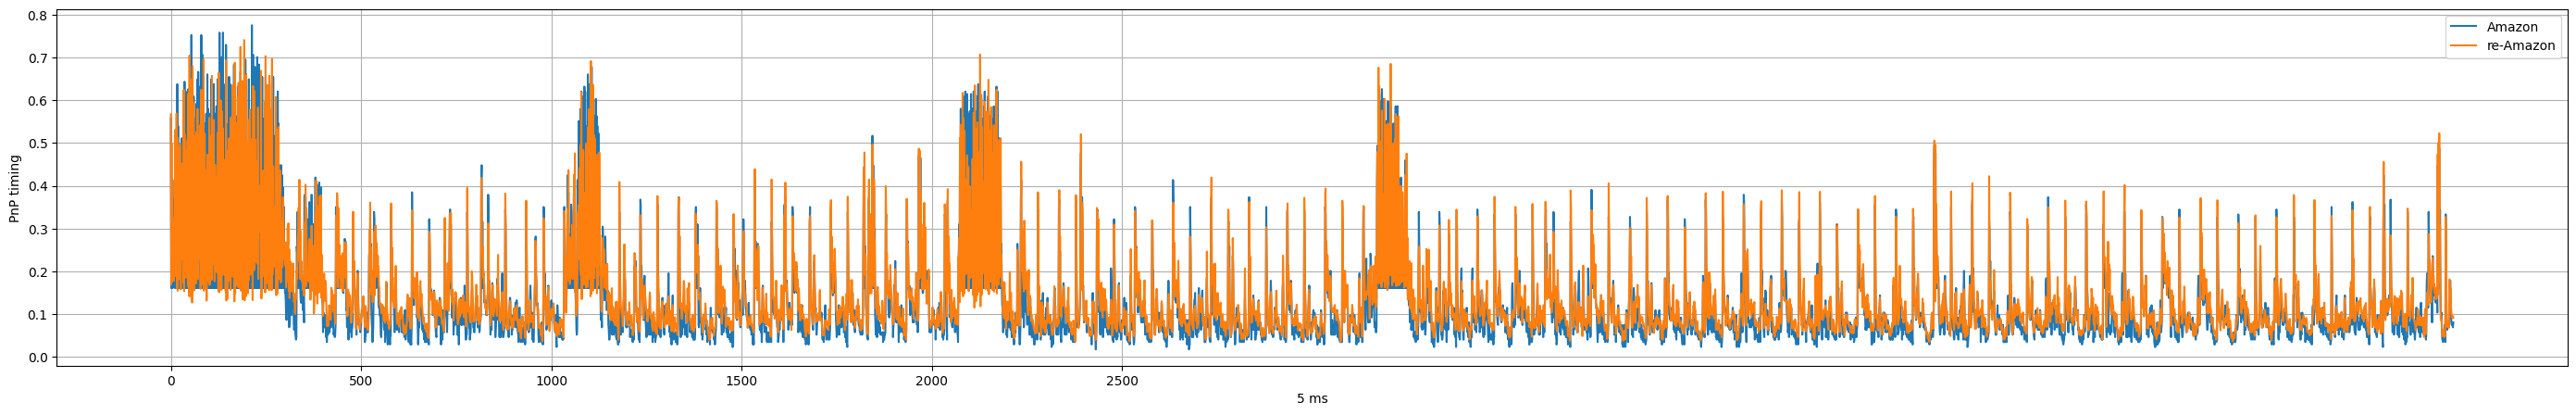

In [421]:
fig = plt.figure(figsize=(35,5))

plt.plot(trainX_test[1],label='Amazon')
plt.plot(re_generated_x[1],label='re-Amazon')

plt.legend()

plt.xticks(np.arange(0, 3000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#fig.savefig('RegeneratedGoogle.jpeg')
#plt.show()

# Load the Pre-trained CNN model

In [422]:
classification_model = tf.keras.models.load_model('/home/seonghun/Research/WebsiteFingerPrinting/CNN/CNN_Pretrained_Model_chrome_W2.h5')

In [423]:
print(re_generated_x.shape)
re_generated_x_save = np.squeeze(re_generated_x)

print(re_generated_x_save.shape)


(200, 6000, 1)
(200, 6000)


In [424]:
#print(trainY)
trainY_ca= keras.utils.to_categorical(trainY)
print(trainY_ca.shape)

(200, 2)


In [425]:
 prediction = np.argmax(classification_model.predict(re_generated_x_save), axis=1)

 print(prediction.shape)
 print(prediction[0:2000])

7/7 [==============================] - 0s 23ms/step
(200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [426]:
test = classification_model.predict(re_generated_x_save)
print(test.shape)

print(test[0][0])
print(test[0][1])
print(test[100][0])
print(test[100][1])
#print(test[0][3])

7/7 [==============================] - 0s 22ms/step
(200, 2)
0.5739551
0.42604485
0.3518726
0.6481274


In [427]:
score = classification_model.evaluate(re_generated_x_save, trainY_ca, verbose=0)
print(" loss:", score[0])
print("accuracy:", score[1])
print(score)

 loss: 0.4436568021774292
accuracy: 1.0
[0.4436568021774292, 1.0]


In [437]:
new_z_each = Lambda(sampling)([Website_Noise_each_web, z_log_var])
np.array(new_z_each)
print(type(new_z_each))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [438]:
generated_x_noise_each = vae.decoder.predict(new_z_each)
print(generated_x_noise_each.shape)
#print(reconstructed_x[0,:].shape)


7/7 [==============================] - 0s 40ms/step
(200, 6000, 1)


Text(0, 0.5, 'PnP timing')

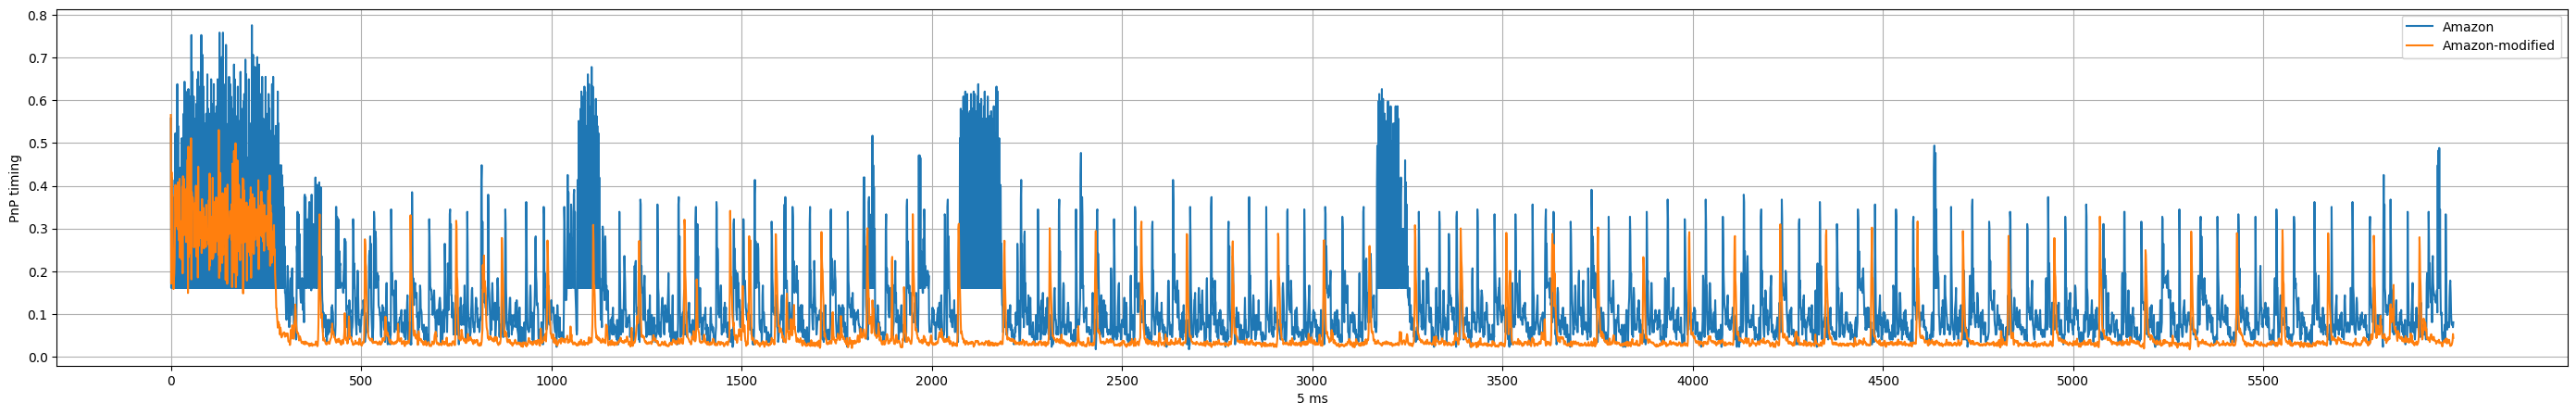

In [440]:
fig = plt.figure(figsize=(35,5))
plt.plot(trainX_test[1],label='Amazon')
plt.plot(generated_x_noise_each[1],label='Amazon-modified')

plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")


In [441]:
generated_x_noise_each_save = np.squeeze(generated_x_noise_each)
print(generated_x_noise_each_save.shape)

(200, 6000)


In [442]:
prediction_new = np.argmax(classification_model.predict(generated_x_noise_each_save), axis=1)

print(prediction_new.shape)
print(prediction_new[0:1000])

7/7 [==============================] - 0s 22ms/step
(200,)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1
 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [446]:
score_noise = classification_model.evaluate(generated_x_noise_each_save, trainY_ca, verbose=0)
print(" loss:", score_noise[0])
print("accuracy:", score_noise[1])
print(score_noise)
#print("accuracy:", score[1])

 loss: 0.7037792205810547
accuracy: 0.5400000214576721
[0.7037792205810547, 0.5400000214576721]


# Save reconstructed WF dataset and noisy WF dataset

In [ ]:
with open('reconstructed_x_chrome_w2.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(re_generated_x_save)

with open('reconstructed_nosiy_x_chrome_w2.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(generated_x_noise_each_save)

# End of the explanations 

# --------- Some extra experiments ---------------

In [429]:
print(dist.shape)

(2, 2, 2)


In [430]:
print(dist)

[[[ 0.          0.        ]
  [-2.43390703  1.23086858]]

 [[ 2.43390703 -1.23086858]
  [ 0.          0.        ]]]


In [432]:
new_z = Lambda(sampling)([Website_Noise_mean, z_log_var])
np.array(new_z)
print(type(new_z))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [433]:
generated_x_noise = vae.decoder.predict(new_z)
print(generated_x_noise.shape)
#print(reconstructed_x[0,:].shape)


7/7 [==============================] - 0s 39ms/step
(200, 6000, 1)


# Each Distance

## playing in latent space

In [434]:
print(Website_Noise_each_web)

[[-3.00043374e-01  1.62321016e-01]
 [ 2.30447295e+00 -7.68350720e-01]
 [ 8.67636919e-01  7.42192864e-01]
 [ 1.71001267e+00 -1.44793558e+00]
 [-1.54545033e+00 -1.46925974e+00]
 [-5.21813631e-01 -1.86600626e+00]
 [-7.66881347e-01 -7.34112263e-01]
 [ 3.55646336e+00 -7.76452184e-01]
 [-2.40982199e+00 -1.25245643e+00]
 [ 8.16903353e-01 -1.88832998e+00]
 [ 2.91198939e-01  1.11435719e-01]
 [ 1.95076737e+00 -9.91555586e-01]
 [-7.47531772e-01  1.74762055e-01]
 [ 1.97351125e+00 -3.17193151e-01]
 [-1.04578507e+00 -6.23248339e-01]
 [ 1.98020223e+00 -1.16238791e+00]
 [-7.21546888e-01 -1.43127823e+00]
 [ 2.27116604e+00 -1.63571101e+00]
 [-1.22309041e+00  6.85550690e-01]
 [ 2.12012354e+00 -1.45610127e+00]
 [-2.77505696e-01  3.76702756e-01]
 [-1.66877699e+00 -1.54334897e+00]
 [ 1.36651063e+00  1.45781231e+00]
 [ 2.27236128e+00  5.27954102e-03]
 [ 2.92147338e-01 -2.94201821e-01]
 [ 3.94794703e-01  2.30552554e-01]
 [-2.69945216e+00  3.15881699e-01]
 [ 2.70218220e+00 -1.82064760e+00]
 [-2.41473055e+00 -8

In [435]:
print(Website_Noise_each_web.shape)

(200, 2)


In [84]:
Latent_train, Latent_valid, Latent_y_train, Latent_y_valid = train_test_split(X_valid_encoded_ori, trainY[:,0] ,test_size=0.2)

print("--------------Data--------------")
print("Orignal X shape: {}".format(Website_Noise_each_web.shape))
print("Origianl Y shape: {}".format(trainY[:,0].shape))

print("--------------Train Data--------------")
print("X_train shape: {}".format(Latent_train.shape))
print("y_train shape: {}".format(Latent_y_train.shape))

print("--------------Validation Data--------------")
print("X_val shape: {}".format(Latent_valid.shape))
print("y_val shape: {}".format(Latent_y_valid.shape))


--------------Data--------------
Orignal X shape: (10000, 100)
Origianl Y shape: (10000,)
--------------Train Data--------------
X_train shape: (8000, 100)
y_train shape: (8000,)
--------------Validation Data--------------
X_val shape: (2000, 100)
y_val shape: (2000,)


In [85]:
clf6.fit(Latent_train,Latent_y_train)

MLPClassifier()

In [86]:
print(accuracy_score(Latent_y_valid, clf6.predict(Latent_valid)))

0.8955


In [87]:
new_z_each = Lambda(sampling)([Website_Noise_each_web, z_log_var])
#new_z = Lambda(sampling)([z_mean, z_log_var])
#print(new_z)
np.array(new_z_each)

print(type(new_z_each))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [88]:
generated_x_noise_each = vae.decoder.predict(new_z_each)
print(generated_x_noise_each.shape)
#print(reconstructed_x[0,:].shape)


(10000, 6000, 1)


Text(0, 0.5, 'PnP timing')

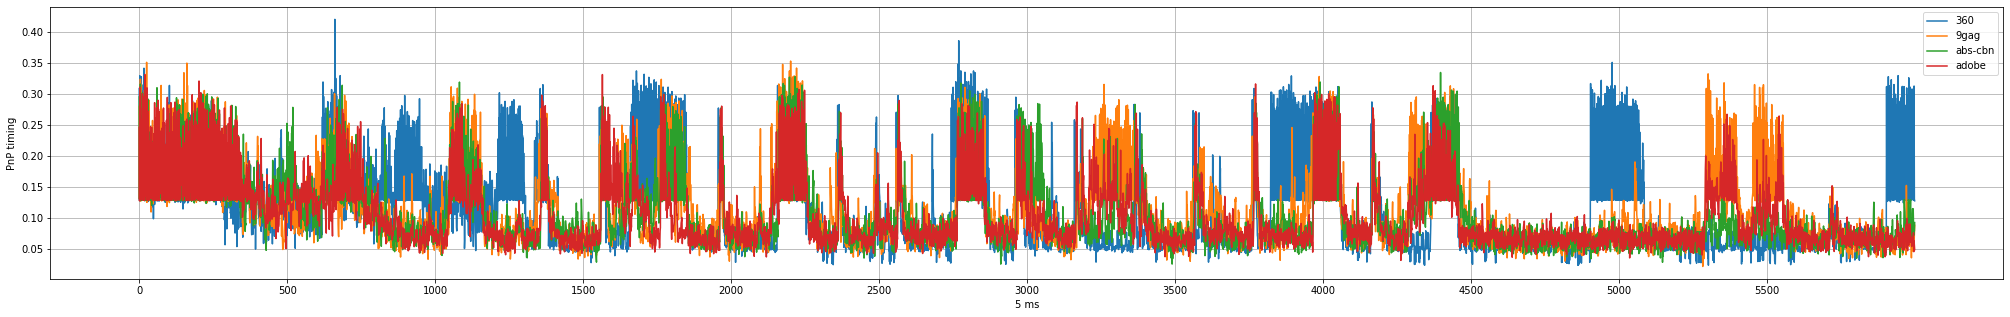

In [89]:

fig = plt.figure(figsize=(35,5))

#for i in range (1,400,100):
#  plt.plot(generated_x_noise_each[i],label=i)


plt.plot(generated_x_noise_each[0],label='360')
plt.plot(generated_x_noise_each[100],label='9gag')
plt.plot(generated_x_noise_each[200],label='abs-cbn')
plt.plot(generated_x_noise_each[300],label='adobe')


plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")


In [90]:
generated_x_noise_each_save = np.squeeze(generated_x_noise_each)
print(generated_x_noise_each_save.shape)

(10000, 6000)


In [92]:
prediction_new = np.argmax(classification_model.predict(generated_x_noise_each_save), axis=1)

print(prediction_new.shape)
print(prediction_new[0:1000])

(10000,)
[ 0 18  2  3  4  5  6  7  8  9 77 13 38 10 92 96 56 17 18 18 52 88 18 23
 39 25 92 17 89 44 30 20 96 96  0 35 36 90 35 97 80 96 42 20 44 45 46 20
 48 49 50 96 52 53 54  5 56 54 10 89 60 61 62 22  5 56 97 67 10 97 70 71
  0 73 43 75 52 57 88 79 80 75 82 11 20 20 14 93 88 52 90 91 92 93 97  0
 18 97  0  0  0  1  2  3  4  5  6 38 72 36 10 11 12 13 97  1 56 17 18  1
 20 82 52 23 24 13 82 90 92 93 30 20  1 20 34 35 36 92 38 97 40  1 42 43
 44 92 46 47 35 49 50  1 52 83 54 97 56 57 58 78 60 61 62 56 38 65 20 67
 68 66 70 71 72 46  1 75 76 77 78 79 80 92 82 83  1 11 64 87 20 89 90 91
 92 93 94 95 18 97 98 99 44 20  2  3  4 52  6  7 72  9 10 59 23 13 14 43
 90 17 18 20 97 21 22 23 88 25 82 27 77 44 30 20 20 82 37 35 36 92 38 55
 11 20 42 20 44 45 46 47 48 49 50 20 52 11 54 52 56 57 56 13 60 61 62 63
 52 65 66 67 68 89 70 71 72 58 96 56 76 77 78 79 80 75 82 59 51 43 86 87
 88 67 90 91 92 93 94 95 96 97 98 99 44 20  2  3  4  5  6  7  8  9 10 11
 12 13 97 43 90 17 18 51 20 55 22 23 24 25

In [93]:
prediction_new_score = classification_model.predict(generated_x_noise_each_save)

print(prediction_new_score.shape)
print(prediction_new_score[2])
print(prediction_new_score[1][1],prediction_new_score[1][20])

import heapq
import numpy

heapq.nlargest(10, range(len(prediction_new_score[2])), prediction_new_score[2].take)


#heapq.nlargest(3, range(len(prediction_new_score)), prediction_new_score.__getitem__)


(10000, 100)
[2.15917895e-10 2.19088281e-09 9.38880801e-01 6.09893501e-02
 8.89044394e-10 7.39944911e-11 2.76863088e-10 3.66061140e-11
 8.52296762e-06 3.84141003e-07 9.60802726e-09 1.82364765e-05
 2.04666526e-06 7.51977859e-06 7.66510466e-11 6.51154044e-13
 1.22108986e-06 4.17977475e-08 2.25286627e-13 3.41595090e-08
 1.25367273e-12 1.45123297e-11 7.86295404e-11 2.24820687e-05
 2.35667930e-08 4.87384044e-09 1.05223322e-07 7.99362354e-10
 1.39482296e-07 7.79490321e-08 1.72110692e-09 2.07110062e-08
 1.17190233e-11 5.62219162e-13 3.70354268e-11 1.03052700e-09
 4.36297637e-10 1.38569050e-07 2.15001172e-09 1.48906410e-14
 1.98645397e-12 4.38128266e-13 3.34273076e-09 6.09941875e-10
 2.20860315e-07 3.71555342e-09 1.65696856e-05 9.73831016e-11
 4.63015903e-10 4.04418010e-09 2.92624480e-09 1.48751996e-14
 3.90940730e-15 9.87648647e-08 3.48060354e-07 9.13385379e-16
 8.74914637e-12 1.90300076e-12 3.34421969e-07 6.21286745e-06
 4.45365056e-12 5.94122028e-13 1.03601542e-13 1.65380687e-08
 1.43520330

[2, 3, 83, 23, 11, 46, 8, 88, 13, 59]

In [94]:
score_noise = classification_model.evaluate(generated_x_noise_each_save, trainY_ca, verbose=0)
print(" loss:", score_noise[0])
print("accuracy:", score_noise[1])
print(score_noise)
#print("accuracy:", score[1])

 loss: 15.015559196472168
accuracy: 0.03150000050663948
[15.015559196472168, 0.03150000050663948]


In [95]:
#with open('textfile.txt_noise', 'w',encoding='utf-8') as f:
#    f.write(str(score_noise[1])+'\n')

In [96]:
trainY_test = np.ones((10000,1))
#trainY_test_v = np.ones((10000,1))

for k in range (0,100):
    for i in range (0,100):
        trainY_test[i+k*100]=int(i)
    
#trainY_test=
print(trainY_test.shape)
print(trainY_test[800:10000])


(10000, 1)
[[ 0.]
 [ 1.]
 [ 2.]
 ...
 [97.]
 [98.]
 [99.]]


In [97]:
trainY_test_ca= keras.utils.to_categorical(trainY_test)

In [98]:
score_noise_test = classification_model.evaluate(generated_x_noise_each_save, trainY_test_ca, verbose=0)
print(" loss:", score_noise_test[0])
print("accuracy:", score_noise_test[1])
print(score_noise_test)
#print("accuracy:", score[1])

 loss: 1.887593388557434
accuracy: 0.5963000059127808
[1.887593388557434, 0.5963000059127808]


In [99]:
#print(trainY)
#trainY_test_re=np.reshape(trainY_test,(10000))

#trainY_test_ca= keras.utils.to_categorical(trainY_test_re)
#print(trainY_test_ca.shape)


In [100]:
print(type(prediction_new))
print(type(trainY_test))

prediction_new=np.reshape(prediction_new,(10000))
trainY_test_re=np.reshape(trainY_test,(10000))

print(prediction_new)
print(trainY_test_re)

print(prediction_new.shape,trainY_test_re.shape)

extraction=prediction_new- trainY_test_re

print(extraction.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ 0 18  2 ... 97 98 99]
[ 0.  1.  2. ... 97. 98. 99.]
(10000,) (10000,)
(10000,)


In [134]:
print(extraction[0:100])

[  0.  17.   0.   0.   0.   0.   0.   0.   0.   0.  67.   2.  26.  -3.
  78.  81.  40.   0.   0.  -1.  32.  67.  -4.   0.  15.   0.  66. -10.
  61.  15.   0. -11.  64.  63. -34.   0.   0.  53.  -3.  58.  40.  55.
   0. -23.   0.   0.   0. -27.   0.   0.   0.  45.   0.   0.   0. -50.
   0.  -3. -48.  30.   0.   0.   0. -41. -59.  -9.  31.   0. -58.  28.
   0.   0. -72.   0. -31.   0. -24. -20.  10.   0.   0.  -6.   0. -72.
 -64. -65. -72.   6.   0. -37.   0.   0.   0.   0.   3. -95. -78.   0.
 -98. -99.]


In [135]:
from collections import Counter

for i in range (0,10000,100):
    locals()['web_'+str(i)]=extraction[0+i:100+i]

    
#extracted correct
webs = [extraction[i:i + 100] for i in range(0, len(extraction), 100)]
webs=np.asarray(webs)
print(web_0)

#index that correctly change to websites
for j in range (0,100):
    locals()['ind_'+str(j)]=([i for i,x in enumerate(webs[j]) if x==0])
    #temp=([i for i,x in enumerate(webs[j]) if x==0])
    
for k in range (0,100):
    print(locals()['ind_'+str(k)])
    
print("@@@@@@@@")
#print(temp[0])

total_test = []
#print(ind_0+ind_1+ind_2)
for k in range (0,100):
    total_test = total_test + locals()['ind_'+str(k)]
    
#total = np.concatenate((ind_0,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9))

print(total_test)
print("@@@@@@@@")
count_total = Counter(total_test)
print(count_total)

[  0.  17.   0.   0.   0.   0.   0.   0.   0.   0.  67.   2.  26.  -3.
  78.  81.  40.   0.   0.  -1.  32.  67.  -4.   0.  15.   0.  66. -10.
  61.  15.   0. -11.  64.  63. -34.   0.   0.  53.  -3.  58.  40.  55.
   0. -23.   0.   0.   0. -27.   0.   0.   0.  45.   0.   0.   0. -50.
   0.  -3. -48.  30.   0.   0.   0. -41. -59.  -9.  31.   0. -58.  28.
   0.   0. -72.   0. -31.   0. -24. -20.  10.   0.   0.  -6.   0. -72.
 -64. -65. -72.   6.   0. -37.   0.   0.   0.   0.   3. -95. -78.   0.
 -98. -99.]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 17, 18, 23, 25, 30, 35, 36, 42, 44, 45, 46, 48, 49, 50, 52, 53, 54, 56, 60, 61, 62, 67, 70, 71, 73, 75, 79, 80, 82, 88, 90, 91, 92, 93, 97]
[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 17, 18, 20, 23, 24, 30, 34, 35, 36, 38, 40, 42, 43, 44, 46, 47, 49, 50, 52, 54, 56, 57, 58, 60, 61, 62, 65, 67, 68, 70, 71, 72, 75, 76, 77, 78, 79, 80, 82, 83, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]
[2, 3, 4, 6, 7, 9, 10, 13, 14, 17, 18, 21, 22, 23, 25, 27, 30, 35, 36, 38, 42, 44

Text(0, 0.5, 'PnP timing')

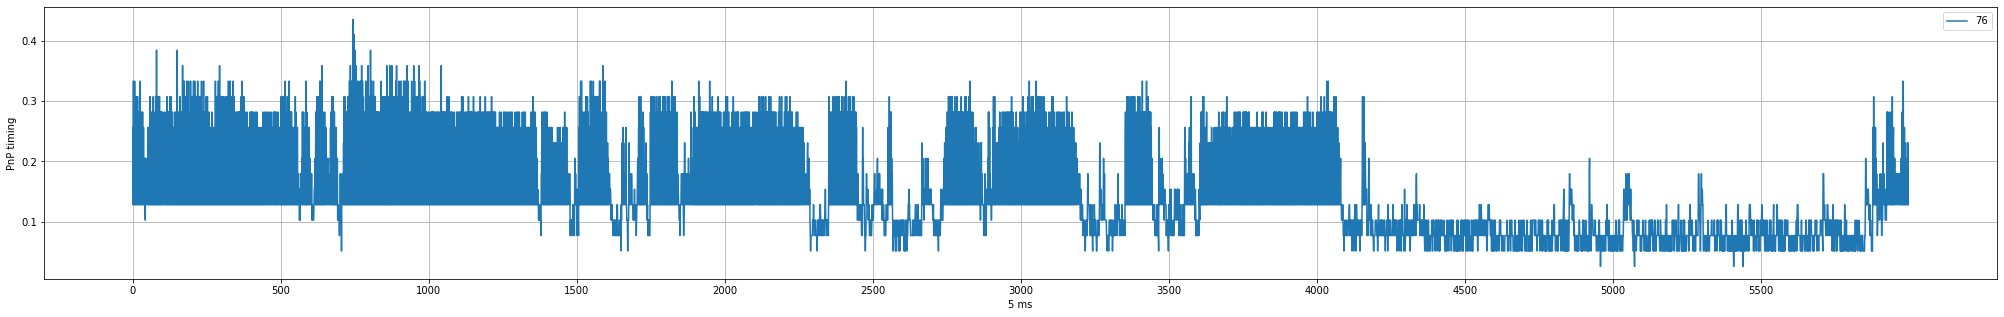

In [136]:
fig = plt.figure(figsize=(35,5))

'''
for i in range (1,100,100):
  #plt.plot(trainX_test[i],label=i)
  plt.plot(re_generated_x[i],label=i)
  plt.plot(generated_x_noise[i],label=i)
'''
#plt.plot(re_generated_x[4000],label='re-google')
#plt.plot(generated_x_noise_each[4000],label='re-google_noise')
plt.plot(trainX_test[8805],label='76')
#plt.plot(re_generated_x[5],label='76')
#plt.plot(generated_x_noise_each[5],label='76')
#plt.plot(re_generated_x[7600],label='76')


plt.legend()
#plt.yticks(np.arange(0, 1, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)

#fig.savefig('ReconstrucedData20.png')
#plt.show()

# Single Test

In [137]:
print(ind_0)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 17, 18, 23, 25, 30, 35, 36, 42, 44, 45, 46, 48, 49, 50, 52, 53, 54, 56, 60, 61, 62, 67, 70, 71, 73, 75, 79, 80, 82, 88, 90, 91, 92, 93, 97]


In [138]:
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')  
print('test----------------------------------------------------------------')    
#print(dist)
print(dist[0,1,:])

test_website = 0
test_measure  = 0 #locals()['ind_'+str(k)][1]
print(test_measure)


'''
print(len(ind_0))

for j in range (0,len(ind_0)):
    temp=ind_0[j]
    
    for i in range (0,100):
        ex_t[i,:] = dist[test_website,temp,:]
        ex_total_t[:,0+k:100+k,:] = ex
        
'''
ex = np.zeros((measurement,latent_dim))





for i in range (0,100):
    ex[i,:] = dist[test_website,test_measure,:]   #dist[web0,meauremet5]
    
    
print('----------------------------------------------------------------')
ex_total= np.zeros((Num_websites,measurement,latent_dim))    

for k in range (0,100,Num_websites):
    ex_total[:,0+k:Num_websites+k,:] = ex

    

print('extended version')
print(ex.shape)

print('Website')
print(websites[test_website,:].shape)
print(websites[test_website,:])
print('extended version')
print(ex)
print('extended total version')
print(ex_total.shape)
print(ex_total)


Website_Noise_each_web_test = websites - ex_total
print('result')
print(Website_Noise_each_web_test)

Website_Noise_each_web_test=np.reshape(Website_Noise_each_web_test,(Num_websites*measurement,latent_dim))

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test----------------------------------------------------------------
[ 2.01218233e-01  3.79656106e-02 -1.07464939e-01  4.19339873e-02
  3.83454636e-02 -1.91340864e-01  3.09760988e-01  1.17289603e-01
  2.84630090e-01 -3.54947710e+00 -2.46896684e-01 -3.47827077e-02
  5.38696289e-01  1.36345252e-01 -3.76101315e-01 -9.16123539e-02
 -7.54995048e-02 -9.94057298e-01  6.44971550e-01 -2.62785912e-01
 -7.46980608e-02  8.08390737e-01 -5.63714743e-01 -1.64687514e-01
 -6.23805225e-02  8.38570744e-02 -2.12289274e-01 -1.66211903e-01
  1.61529273e-01 -3.90328988e-02  3.89454275e-01  9.98259783e-02
 -3.21348369e-01  3.79267931e-02  3.43198240e-01  1.66273326e-01
 -3.70684922e-01 -5.11674106e-01 -3.50695923e-02 -3.28180492e-01
 -1.37201473e-01 -2.27317885e-02 -1.95944682e-01 -1.63246453e-01
  3.16171199e-01 -4.43943441e-02  2.03392535e-01  3.27464119e-02
  1.69027299e-01  1.47937417e+00  4.90323678e-02  3.58972728e-01
  5.53961061e-02 -4.16255653e-01  5.7554

In [139]:
new_z_each_test = Lambda(sampling)([Website_Noise_each_web_test, z_log_var])
#new_z = Lambda(sampling)([z_mean, z_log_var])
#print(new_z)
np.array(new_z_each_test)

print(type(new_z_each_test))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [140]:
generated_x_noise_each_test = vae.decoder.predict(new_z_each_test)
print(generated_x_noise_each_test.shape)
#print(reconstructed_x[0,:].shape)


(10000, 6000, 1)


Text(0, 0.5, 'PnP timing')

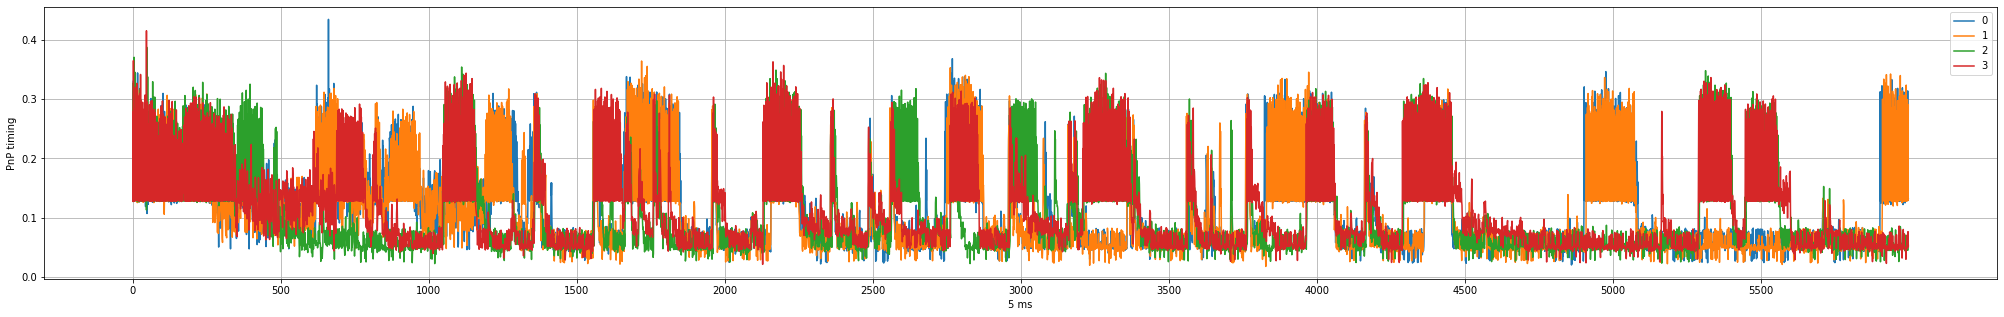

In [141]:

fig = plt.figure(figsize=(35,5))

plt.plot(generated_x_noise_each_test[0],label='0')
plt.plot(generated_x_noise_each_test[1],label='1')
plt.plot(generated_x_noise_each_test[2],label='2')
plt.plot(generated_x_noise_each_test[3],label='3')


plt.legend()
#plt.yticks(np.arange(0, 1, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)

#fig.savefig('ReconstrucedData2_new.png')
#plt.show()

In [142]:
generated_x_noise_each_test_save = np.squeeze(generated_x_noise_each_test)
print(generated_x_noise_each_test_save.shape)

(10000, 6000)


In [143]:
prediction_new_test = np.argmax(classification_model.predict(generated_x_noise_each_test_save), axis=1)

print(prediction_new_test.shape)
print(prediction_new_test[test_website*100:test_website*100+100])
#print(prediction_new_test[1000:1100])

(10000,)
[ 0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0 44 44  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 44  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0
  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [144]:
count_web = Counter(prediction_new_test[test_website*100:test_website*100+100])
print(count_web)
print(test_measure)
print(int(count_web[test_measure])/100 )

Counter({0: 94, 44: 5, 80: 1})
0
0.94


In [145]:
def accuracy_fuction(test_website,test_measure):
    #print(test_website,test_measure)
    #print(test_measure)
    
    ex = np.zeros((measurement,latent_dim))
    
    for i in range (0,100):
        ex[i,:] = dist[test_website,test_measure,:]   #if web 0, meausrement 5 -> dist[web0,meauremet5]
        
    print('----------------------------------------------------------------')
    ex_total= np.zeros((Num_websites,measurement,latent_dim))    
    
    for k in range (0,100,Num_websites):
        ex_total[:,0+k:Num_websites+k,:] = ex
        
    #print('extended version')
    #print(ex.shape)
    
    #print('Website')
    #print(websites[test_website,:].shape)
    #print(websites[test_website,:])
    #print('extended version')
    #print(ex)
    #print('extended total version')
    #print(ex_total.shape)
    #print(ex_total)
    
    Website_Noise_each_web_test = websites - ex_total
    #print('result')
    #print(Website_Noise_each_web_test)
    
    Website_Noise_each_web_test=np.reshape(Website_Noise_each_web_test,(Num_websites*measurement,latent_dim))
    
    new_z_each_test = Lambda(sampling)([Website_Noise_each_web_test, z_log_var])
    #new_z = Lambda(sampling)([z_mean, z_log_var])
    #print(new_z)
    np.array(new_z_each_test)
    #print(type(new_z_each_test))
    
    
    
    #DECODER
    generated_x_noise_each_test = vae.decoder.predict(new_z_each_test)
    #print(generated_x_noise_each_test.shape)
    #print(reconstructed_x[0,:].shape)
    generated_x_noise_each_test_save = np.squeeze(generated_x_noise_each_test)
    #print(generated_x_noise_each_test_save.shape)
    prediction_new_test = np.argmax(classification_model.predict(generated_x_noise_each_test_save), axis=1)
    #print(prediction_new_test.shape)
    #print(prediction_new_test[test_website*100:test_website*100+100])
    count_web = Counter(prediction_new_test[test_website*100:test_website*100+100])
    #print(count_web)
    #print(test_measure)
    print(test_website,test_measure,' - accuracy : ', int(count_web[test_measure])/100)
    #print(int(count_web[test_measure])/100 )
    #print('----------------------------------------------------------------')
    return int(count_web[test_measure])/100

In [146]:
result=accuracy_fuction(0,0)

----------------------------------------------------------------
0 0  - accuracy :  0.95


In [147]:
print(result)

0.95


In [148]:
result_test= np.zeros((100,100)) 
for i in range (0,5):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
0 0  - accuracy :  0.94
----------------------------------------------------------------
0 1  - accuracy :  0.0
----------------------------------------------------------------
0 2  - accuracy :  0.63
----------------------------------------------------------------
0 3  - accuracy :  0.79
----------------------------------------------------------------
0 4  - accuracy :  0.49
----------------------------------------------------------------
0 5  - accuracy :  0.56
----------------------------------------------------------------
0 6  - accuracy :  0.66
----------------------------------------------------------------
0 7  - accuracy :  0.66
----------------------------------------------------------------
0 8  - accuracy :  0.78
----------------------------------------------------------------
0 9  - accuracy :  0.61
----------------------------------------------------------------
0 10  - accuracy :  0.78
---------------------

0 91  - accuracy :  0.68
----------------------------------------------------------------
0 92  - accuracy :  0.72
----------------------------------------------------------------
0 93  - accuracy :  0.71
----------------------------------------------------------------
0 94  - accuracy :  0.66
----------------------------------------------------------------
0 95  - accuracy :  0.39
----------------------------------------------------------------
0 96  - accuracy :  0.55
----------------------------------------------------------------
0 97  - accuracy :  0.53
----------------------------------------------------------------
0 98  - accuracy :  0.91
----------------------------------------------------------------
0 99  - accuracy :  0.68
----------------------------------------------------------------
1 0  - accuracy :  0.38
----------------------------------------------------------------
1 1  - accuracy :  0.98
----------------------------------------------------------------
1 2  - accur

1 83  - accuracy :  0.67
----------------------------------------------------------------
1 84  - accuracy :  0.07
----------------------------------------------------------------
1 85  - accuracy :  0.27
----------------------------------------------------------------
1 86  - accuracy :  0.35
----------------------------------------------------------------
1 87  - accuracy :  0.91
----------------------------------------------------------------
1 88  - accuracy :  0.39
----------------------------------------------------------------
1 89  - accuracy :  0.73
----------------------------------------------------------------
1 90  - accuracy :  0.99
----------------------------------------------------------------
1 91  - accuracy :  0.97
----------------------------------------------------------------
1 92  - accuracy :  0.96
----------------------------------------------------------------
1 93  - accuracy :  0.94
----------------------------------------------------------------
1 94  - ac

2 75  - accuracy :  0.64
----------------------------------------------------------------
2 76  - accuracy :  0.38
----------------------------------------------------------------
2 77  - accuracy :  0.87
----------------------------------------------------------------
2 78  - accuracy :  0.6
----------------------------------------------------------------
2 79  - accuracy :  0.97
----------------------------------------------------------------
2 80  - accuracy :  1.0
----------------------------------------------------------------
2 81  - accuracy :  0.28
----------------------------------------------------------------
2 82  - accuracy :  0.81
----------------------------------------------------------------
2 83  - accuracy :  0.68
----------------------------------------------------------------
2 84  - accuracy :  0.0
----------------------------------------------------------------
2 85  - accuracy :  0.01
----------------------------------------------------------------
2 86  - accur

3 67  - accuracy :  0.99
----------------------------------------------------------------
3 68  - accuracy :  0.93
----------------------------------------------------------------
3 69  - accuracy :  0.02
----------------------------------------------------------------
3 70  - accuracy :  0.93
----------------------------------------------------------------
3 71  - accuracy :  0.99
----------------------------------------------------------------
3 72  - accuracy :  0.98
----------------------------------------------------------------
3 73  - accuracy :  0.29
----------------------------------------------------------------
3 74  - accuracy :  0.0
----------------------------------------------------------------
3 75  - accuracy :  0.73
----------------------------------------------------------------
3 76  - accuracy :  0.45
----------------------------------------------------------------
3 77  - accuracy :  0.94
----------------------------------------------------------------
3 78  - acc

4 59  - accuracy :  0.31
----------------------------------------------------------------
4 60  - accuracy :  0.95
----------------------------------------------------------------
4 61  - accuracy :  0.96
----------------------------------------------------------------
4 62  - accuracy :  0.99
----------------------------------------------------------------
4 63  - accuracy :  0.87
----------------------------------------------------------------
4 64  - accuracy :  0.45
----------------------------------------------------------------
4 65  - accuracy :  0.98
----------------------------------------------------------------
4 66  - accuracy :  0.33
----------------------------------------------------------------
4 67  - accuracy :  1.0
----------------------------------------------------------------
4 68  - accuracy :  0.86
----------------------------------------------------------------
4 69  - accuracy :  0.05
----------------------------------------------------------------
4 70  - acc

In [149]:
for i in range (5,10):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
5 0  - accuracy :  0.28
----------------------------------------------------------------
5 1  - accuracy :  0.01
----------------------------------------------------------------
5 2  - accuracy :  0.87
----------------------------------------------------------------
5 3  - accuracy :  0.99
----------------------------------------------------------------
5 4  - accuracy :  0.94
----------------------------------------------------------------
5 5  - accuracy :  1.0
----------------------------------------------------------------
5 6  - accuracy :  0.95
----------------------------------------------------------------
5 7  - accuracy :  0.8
----------------------------------------------------------------
5 8  - accuracy :  0.83
----------------------------------------------------------------
5 9  - accuracy :  0.91
----------------------------------------------------------------
5 10  - accuracy :  0.99
----------------------

5 91  - accuracy :  1.0
----------------------------------------------------------------
5 92  - accuracy :  0.99
----------------------------------------------------------------
5 93  - accuracy :  0.98
----------------------------------------------------------------
5 94  - accuracy :  1.0
----------------------------------------------------------------
5 95  - accuracy :  0.79
----------------------------------------------------------------
5 96  - accuracy :  0.42
----------------------------------------------------------------
5 97  - accuracy :  0.81
----------------------------------------------------------------
5 98  - accuracy :  0.99
----------------------------------------------------------------
5 99  - accuracy :  0.9
----------------------------------------------------------------
6 0  - accuracy :  0.41
----------------------------------------------------------------
6 1  - accuracy :  0.0
----------------------------------------------------------------
6 2  - accuracy 

6 83  - accuracy :  0.62
----------------------------------------------------------------
6 84  - accuracy :  0.02
----------------------------------------------------------------
6 85  - accuracy :  0.03
----------------------------------------------------------------
6 86  - accuracy :  0.41
----------------------------------------------------------------
6 87  - accuracy :  0.95
----------------------------------------------------------------
6 88  - accuracy :  0.33
----------------------------------------------------------------
6 89  - accuracy :  0.51
----------------------------------------------------------------
6 90  - accuracy :  0.97
----------------------------------------------------------------
6 91  - accuracy :  0.98
----------------------------------------------------------------
6 92  - accuracy :  0.99
----------------------------------------------------------------
6 93  - accuracy :  0.98
----------------------------------------------------------------
6 94  - ac

7 75  - accuracy :  0.64
----------------------------------------------------------------
7 76  - accuracy :  0.47
----------------------------------------------------------------
7 77  - accuracy :  0.78
----------------------------------------------------------------
7 78  - accuracy :  0.58
----------------------------------------------------------------
7 79  - accuracy :  0.92
----------------------------------------------------------------
7 80  - accuracy :  0.96
----------------------------------------------------------------
7 81  - accuracy :  0.28
----------------------------------------------------------------
7 82  - accuracy :  0.88
----------------------------------------------------------------
7 83  - accuracy :  0.4
----------------------------------------------------------------
7 84  - accuracy :  0.0
----------------------------------------------------------------
7 85  - accuracy :  0.0
----------------------------------------------------------------
7 86  - accur

8 67  - accuracy :  0.99
----------------------------------------------------------------
8 68  - accuracy :  0.96
----------------------------------------------------------------
8 69  - accuracy :  0.03
----------------------------------------------------------------
8 70  - accuracy :  0.87
----------------------------------------------------------------
8 71  - accuracy :  0.87
----------------------------------------------------------------
8 72  - accuracy :  0.85
----------------------------------------------------------------
8 73  - accuracy :  0.24
----------------------------------------------------------------
8 74  - accuracy :  0.0
----------------------------------------------------------------
8 75  - accuracy :  0.77
----------------------------------------------------------------
8 76  - accuracy :  0.4
----------------------------------------------------------------
8 77  - accuracy :  0.88
----------------------------------------------------------------
8 78  - accu

9 59  - accuracy :  0.31
----------------------------------------------------------------
9 60  - accuracy :  0.91
----------------------------------------------------------------
9 61  - accuracy :  0.97
----------------------------------------------------------------
9 62  - accuracy :  0.99
----------------------------------------------------------------
9 63  - accuracy :  0.62
----------------------------------------------------------------
9 64  - accuracy :  0.23
----------------------------------------------------------------
9 65  - accuracy :  0.85
----------------------------------------------------------------
9 66  - accuracy :  0.22
----------------------------------------------------------------
9 67  - accuracy :  1.0
----------------------------------------------------------------
9 68  - accuracy :  0.9
----------------------------------------------------------------
9 69  - accuracy :  0.03
----------------------------------------------------------------
9 70  - accu

In [150]:
print("1")

1


In [152]:
for i in range (10,15):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
10 0  - accuracy :  0.19
----------------------------------------------------------------
10 1  - accuracy :  0.0
----------------------------------------------------------------


ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,1,6000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv1d_transpose/conv1d_transpose (defined at <ipython-input-54-0d075f2ae58e>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_4515288]

Function call stack:
predict_function


In [ ]:
print("1.5")

In [ ]:
for i in range (15,20):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

In [ ]:
print("2")

In [ ]:
for i in range (20,25):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

In [ ]:
for i in range (25,30):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)
    print(torch.cuda.memory_summary())

In [ ]:
print("3")

In [ ]:
print(result_test.shape)
print(result_test[0:30,:])

print(result_test[30:50,:])

In [113]:
for i in range (30,40):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
30 0  - accuracy :  0.67
----------------------------------------------------------------
30 1  - accuracy :  0.0
----------------------------------------------------------------
30 2  - accuracy :  0.07
----------------------------------------------------------------
30 3  - accuracy :  0.36
----------------------------------------------------------------
30 4  - accuracy :  0.04
----------------------------------------------------------------
30 5  - accuracy :  0.96
----------------------------------------------------------------
30 6  - accuracy :  0.88
----------------------------------------------------------------
30 7  - accuracy :  0.27
----------------------------------------------------------------
30 8  - accuracy :  0.1
----------------------------------------------------------------
30 9  - accuracy :  0.19
----------------------------------------------------------------
30 10  - accuracy :  0.07
-----------

30 90  - accuracy :  0.36
----------------------------------------------------------------
30 91  - accuracy :  0.96
----------------------------------------------------------------
30 92  - accuracy :  0.76
----------------------------------------------------------------
30 93  - accuracy :  0.0
----------------------------------------------------------------
30 94  - accuracy :  0.0
----------------------------------------------------------------
30 95  - accuracy :  1.0
----------------------------------------------------------------
30 96  - accuracy :  0.04
----------------------------------------------------------------
30 97  - accuracy :  0.95
----------------------------------------------------------------
30 98  - accuracy :  0.48
----------------------------------------------------------------
30 99  - accuracy :  0.69
----------------------------------------------------------------
31 0  - accuracy :  0.41
----------------------------------------------------------------
31 

31 81  - accuracy :  0.68
----------------------------------------------------------------
31 82  - accuracy :  0.43
----------------------------------------------------------------
31 83  - accuracy :  0.72
----------------------------------------------------------------
31 84  - accuracy :  0.0
----------------------------------------------------------------
31 85  - accuracy :  0.0
----------------------------------------------------------------
31 86  - accuracy :  0.03
----------------------------------------------------------------
31 87  - accuracy :  0.8
----------------------------------------------------------------
31 88  - accuracy :  0.0
----------------------------------------------------------------
31 89  - accuracy :  0.85
----------------------------------------------------------------
31 90  - accuracy :  0.39
----------------------------------------------------------------
31 91  - accuracy :  0.8
----------------------------------------------------------------
31 9

32 72  - accuracy :  0.09
----------------------------------------------------------------
32 73  - accuracy :  0.03
----------------------------------------------------------------
32 74  - accuracy :  0.0
----------------------------------------------------------------
32 75  - accuracy :  0.0
----------------------------------------------------------------
32 76  - accuracy :  0.71
----------------------------------------------------------------
32 77  - accuracy :  0.34
----------------------------------------------------------------
32 78  - accuracy :  0.0
----------------------------------------------------------------
32 79  - accuracy :  0.0
----------------------------------------------------------------
32 80  - accuracy :  0.08
----------------------------------------------------------------
32 81  - accuracy :  0.06
----------------------------------------------------------------
32 82  - accuracy :  0.24
----------------------------------------------------------------
32 

33 63  - accuracy :  0.14
----------------------------------------------------------------
33 64  - accuracy :  0.1
----------------------------------------------------------------
33 65  - accuracy :  0.32
----------------------------------------------------------------
33 66  - accuracy :  0.36
----------------------------------------------------------------
33 67  - accuracy :  0.33
----------------------------------------------------------------
33 68  - accuracy :  0.36
----------------------------------------------------------------
33 69  - accuracy :  0.52
----------------------------------------------------------------
33 70  - accuracy :  0.02
----------------------------------------------------------------
33 71  - accuracy :  0.03
----------------------------------------------------------------
33 72  - accuracy :  0.1
----------------------------------------------------------------
33 73  - accuracy :  0.33
----------------------------------------------------------------
3

34 54  - accuracy :  0.14
----------------------------------------------------------------
34 55  - accuracy :  1.0
----------------------------------------------------------------
34 56  - accuracy :  0.98
----------------------------------------------------------------
34 57  - accuracy :  0.0
----------------------------------------------------------------
34 58  - accuracy :  0.58
----------------------------------------------------------------
34 59  - accuracy :  0.0
----------------------------------------------------------------
34 60  - accuracy :  0.42
----------------------------------------------------------------
34 61  - accuracy :  0.0
----------------------------------------------------------------
34 62  - accuracy :  0.0
----------------------------------------------------------------
34 63  - accuracy :  0.76
----------------------------------------------------------------
34 64  - accuracy :  0.44
----------------------------------------------------------------
35 2

36 5  - accuracy :  0.82
----------------------------------------------------------------
36 6  - accuracy :  0.87
----------------------------------------------------------------
36 7  - accuracy :  0.27
----------------------------------------------------------------
36 8  - accuracy :  0.38
----------------------------------------------------------------
36 9  - accuracy :  0.39
----------------------------------------------------------------
36 10  - accuracy :  0.79
----------------------------------------------------------------
36 11  - accuracy :  0.0
----------------------------------------------------------------
36 12  - accuracy :  0.03
----------------------------------------------------------------
36 13  - accuracy :  0.17
----------------------------------------------------------------
36 14  - accuracy :  0.29
----------------------------------------------------------------
36 15  - accuracy :  0.0
----------------------------------------------------------------
36 16 

36 96  - accuracy :  0.05
----------------------------------------------------------------
36 97  - accuracy :  0.94
----------------------------------------------------------------
36 98  - accuracy :  0.36
----------------------------------------------------------------
36 99  - accuracy :  0.64
----------------------------------------------------------------
37 0  - accuracy :  0.89
----------------------------------------------------------------
37 1  - accuracy :  0.0
----------------------------------------------------------------
37 2  - accuracy :  0.04
----------------------------------------------------------------
37 3  - accuracy :  0.53
----------------------------------------------------------------
37 4  - accuracy :  0.09
----------------------------------------------------------------
37 5  - accuracy :  0.94
----------------------------------------------------------------
37 6  - accuracy :  0.99
----------------------------------------------------------------
37 7  -

37 87  - accuracy :  0.95
----------------------------------------------------------------
37 88  - accuracy :  0.0
----------------------------------------------------------------
37 89  - accuracy :  0.97
----------------------------------------------------------------
37 90  - accuracy :  0.59
----------------------------------------------------------------
37 91  - accuracy :  1.0
----------------------------------------------------------------
37 92  - accuracy :  0.78
----------------------------------------------------------------
37 93  - accuracy :  0.0
----------------------------------------------------------------
37 94  - accuracy :  0.0
----------------------------------------------------------------
37 95  - accuracy :  1.0
----------------------------------------------------------------
37 96  - accuracy :  0.0
----------------------------------------------------------------
37 97  - accuracy :  1.0
----------------------------------------------------------------
37 98 

38 78  - accuracy :  0.0
----------------------------------------------------------------
38 79  - accuracy :  0.0
----------------------------------------------------------------
38 80  - accuracy :  0.96
----------------------------------------------------------------
38 81  - accuracy :  0.96
----------------------------------------------------------------
38 82  - accuracy :  0.19
----------------------------------------------------------------
38 83  - accuracy :  0.92
----------------------------------------------------------------
38 84  - accuracy :  0.0
----------------------------------------------------------------
38 85  - accuracy :  0.0
----------------------------------------------------------------
38 86  - accuracy :  0.0
----------------------------------------------------------------
38 87  - accuracy :  0.84
----------------------------------------------------------------
38 88  - accuracy :  0.0
----------------------------------------------------------------
38 89

39 69  - accuracy :  0.39
----------------------------------------------------------------
39 70  - accuracy :  0.01
----------------------------------------------------------------
39 71  - accuracy :  0.05
----------------------------------------------------------------
39 72  - accuracy :  0.18
----------------------------------------------------------------
39 73  - accuracy :  0.47
----------------------------------------------------------------
39 74  - accuracy :  0.0
----------------------------------------------------------------
39 75  - accuracy :  0.59
----------------------------------------------------------------
39 76  - accuracy :  1.0
----------------------------------------------------------------
39 77  - accuracy :  0.77
----------------------------------------------------------------
39 78  - accuracy :  0.0
----------------------------------------------------------------
39 79  - accuracy :  0.0
----------------------------------------------------------------
39 

In [114]:
print("4")

3


In [116]:
for i in range (40,50):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
40 0  - accuracy :  0.56
----------------------------------------------------------------
40 1  - accuracy :  0.0
----------------------------------------------------------------
40 2  - accuracy :  0.25
----------------------------------------------------------------
40 3  - accuracy :  0.66
----------------------------------------------------------------
40 4  - accuracy :  0.04
----------------------------------------------------------------
40 5  - accuracy :  0.97
----------------------------------------------------------------
40 6  - accuracy :  0.95
----------------------------------------------------------------
40 7  - accuracy :  0.71
----------------------------------------------------------------
40 8  - accuracy :  0.42
----------------------------------------------------------------
40 9  - accuracy :  0.42
----------------------------------------------------------------
40 10  - accuracy :  0.39
----------

40 90  - accuracy :  0.69
----------------------------------------------------------------
40 91  - accuracy :  0.88
----------------------------------------------------------------
40 92  - accuracy :  0.72
----------------------------------------------------------------
40 93  - accuracy :  0.19
----------------------------------------------------------------
40 94  - accuracy :  0.0
----------------------------------------------------------------
40 95  - accuracy :  0.99
----------------------------------------------------------------
40 96  - accuracy :  0.39
----------------------------------------------------------------
40 97  - accuracy :  0.96
----------------------------------------------------------------
40 98  - accuracy :  0.75
----------------------------------------------------------------
40 99  - accuracy :  0.87
----------------------------------------------------------------
41 0  - accuracy :  0.05
----------------------------------------------------------------
4

41 81  - accuracy :  0.22
----------------------------------------------------------------
41 82  - accuracy :  0.15
----------------------------------------------------------------
41 83  - accuracy :  0.26
----------------------------------------------------------------
41 84  - accuracy :  0.0
----------------------------------------------------------------
41 85  - accuracy :  0.0
----------------------------------------------------------------
41 86  - accuracy :  0.02
----------------------------------------------------------------
41 87  - accuracy :  0.62
----------------------------------------------------------------
41 88  - accuracy :  0.0
----------------------------------------------------------------
41 89  - accuracy :  0.39
----------------------------------------------------------------
41 90  - accuracy :  0.14
----------------------------------------------------------------
41 91  - accuracy :  0.28
----------------------------------------------------------------
41

42 72  - accuracy :  0.05
----------------------------------------------------------------
42 73  - accuracy :  0.54
----------------------------------------------------------------
42 74  - accuracy :  0.0
----------------------------------------------------------------
42 75  - accuracy :  0.73
----------------------------------------------------------------
42 76  - accuracy :  0.99
----------------------------------------------------------------
42 77  - accuracy :  0.66
----------------------------------------------------------------
42 78  - accuracy :  0.0
----------------------------------------------------------------
42 79  - accuracy :  0.0
----------------------------------------------------------------
42 80  - accuracy :  0.81
----------------------------------------------------------------
42 81  - accuracy :  0.83
----------------------------------------------------------------
42 82  - accuracy :  0.3
----------------------------------------------------------------
42 

43 63  - accuracy :  0.04
----------------------------------------------------------------
43 64  - accuracy :  0.21
----------------------------------------------------------------
43 65  - accuracy :  0.43
----------------------------------------------------------------
43 66  - accuracy :  0.07
----------------------------------------------------------------
43 67  - accuracy :  0.14
----------------------------------------------------------------
43 68  - accuracy :  0.43
----------------------------------------------------------------
43 69  - accuracy :  0.23
----------------------------------------------------------------
43 70  - accuracy :  0.01
----------------------------------------------------------------
43 71  - accuracy :  0.0
----------------------------------------------------------------
43 72  - accuracy :  0.09
----------------------------------------------------------------
43 73  - accuracy :  0.13
----------------------------------------------------------------


44 54  - accuracy :  0.22
----------------------------------------------------------------
44 55  - accuracy :  0.93
----------------------------------------------------------------
44 56  - accuracy :  0.99
----------------------------------------------------------------
44 57  - accuracy :  0.0
----------------------------------------------------------------
44 58  - accuracy :  0.63
----------------------------------------------------------------
44 59  - accuracy :  0.01
----------------------------------------------------------------
44 60  - accuracy :  0.08
----------------------------------------------------------------
44 61  - accuracy :  0.0
----------------------------------------------------------------
44 62  - accuracy :  0.0
----------------------------------------------------------------
44 63  - accuracy :  0.8
----------------------------------------------------------------
44 64  - accuracy :  0.1
----------------------------------------------------------------
44 6

45 45  - accuracy :  0.93
----------------------------------------------------------------
45 46  - accuracy :  0.03
----------------------------------------------------------------
45 47  - accuracy :  0.0
----------------------------------------------------------------
45 48  - accuracy :  0.02
----------------------------------------------------------------
45 49  - accuracy :  0.0
----------------------------------------------------------------
45 50  - accuracy :  0.0
----------------------------------------------------------------
45 51  - accuracy :  0.0
----------------------------------------------------------------
45 52  - accuracy :  0.1
----------------------------------------------------------------
45 53  - accuracy :  0.03
----------------------------------------------------------------
45 54  - accuracy :  0.03
----------------------------------------------------------------
45 55  - accuracy :  0.02
----------------------------------------------------------------
45 5

46 36  - accuracy :  0.02
----------------------------------------------------------------
46 37  - accuracy :  0.85
----------------------------------------------------------------
46 38  - accuracy :  0.37
----------------------------------------------------------------
46 39  - accuracy :  0.0
----------------------------------------------------------------
46 40  - accuracy :  0.0
----------------------------------------------------------------
46 41  - accuracy :  0.0
----------------------------------------------------------------
46 42  - accuracy :  0.24
----------------------------------------------------------------
46 43  - accuracy :  0.0
----------------------------------------------------------------
46 44  - accuracy :  1.0
----------------------------------------------------------------
46 45  - accuracy :  0.0
----------------------------------------------------------------
46 46  - accuracy :  0.98
----------------------------------------------------------------
46 47

47 27  - accuracy :  0.02
----------------------------------------------------------------
47 28  - accuracy :  0.53
----------------------------------------------------------------
47 29  - accuracy :  0.75
----------------------------------------------------------------
47 30  - accuracy :  0.07
----------------------------------------------------------------
47 31  - accuracy :  0.0
----------------------------------------------------------------
47 32  - accuracy :  0.0
----------------------------------------------------------------
47 33  - accuracy :  0.0
----------------------------------------------------------------
47 34  - accuracy :  0.37
----------------------------------------------------------------
47 35  - accuracy :  0.67
----------------------------------------------------------------
47 36  - accuracy :  0.07
----------------------------------------------------------------
47 37  - accuracy :  0.35
----------------------------------------------------------------
47

48 18  - accuracy :  0.12
----------------------------------------------------------------
48 19  - accuracy :  0.0
----------------------------------------------------------------
48 20  - accuracy :  0.0
----------------------------------------------------------------
48 21  - accuracy :  0.0
----------------------------------------------------------------
48 22  - accuracy :  0.85
----------------------------------------------------------------
48 23  - accuracy :  0.12
----------------------------------------------------------------
48 24  - accuracy :  0.9
----------------------------------------------------------------
48 25  - accuracy :  0.0
----------------------------------------------------------------
48 26  - accuracy :  0.0
----------------------------------------------------------------
48 27  - accuracy :  0.47
----------------------------------------------------------------
48 28  - accuracy :  0.99
----------------------------------------------------------------
48 29

49 9  - accuracy :  0.02
----------------------------------------------------------------
49 10  - accuracy :  0.16
----------------------------------------------------------------
49 11  - accuracy :  0.0
----------------------------------------------------------------
49 12  - accuracy :  0.0
----------------------------------------------------------------
49 13  - accuracy :  0.36
----------------------------------------------------------------
49 14  - accuracy :  0.01
----------------------------------------------------------------
49 15  - accuracy :  0.0
----------------------------------------------------------------
49 16  - accuracy :  0.14
----------------------------------------------------------------
49 17  - accuracy :  0.08
----------------------------------------------------------------
49 18  - accuracy :  0.03
----------------------------------------------------------------
49 19  - accuracy :  0.0
----------------------------------------------------------------
49 2

In [121]:
print("5")

4


In [122]:
for i in range (50,60):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
50 0  - accuracy :  0.64
----------------------------------------------------------------
50 1  - accuracy :  0.0
----------------------------------------------------------------
50 2  - accuracy :  0.32
----------------------------------------------------------------
50 3  - accuracy :  0.7
----------------------------------------------------------------
50 4  - accuracy :  0.18
----------------------------------------------------------------
50 5  - accuracy :  0.92
----------------------------------------------------------------
50 6  - accuracy :  0.92
----------------------------------------------------------------
50 7  - accuracy :  0.65
----------------------------------------------------------------
50 8  - accuracy :  0.42
----------------------------------------------------------------
50 9  - accuracy :  0.32
----------------------------------------------------------------
50 10  - accuracy :  0.05
-----------

50 90  - accuracy :  0.53
----------------------------------------------------------------
50 91  - accuracy :  0.93
----------------------------------------------------------------
50 92  - accuracy :  0.78
----------------------------------------------------------------
50 93  - accuracy :  0.23
----------------------------------------------------------------
50 94  - accuracy :  0.0
----------------------------------------------------------------
50 95  - accuracy :  0.97
----------------------------------------------------------------
50 96  - accuracy :  0.48
----------------------------------------------------------------
50 97  - accuracy :  0.9
----------------------------------------------------------------
50 98  - accuracy :  0.7
----------------------------------------------------------------
50 99  - accuracy :  0.94
----------------------------------------------------------------
51 0  - accuracy :  0.03
----------------------------------------------------------------
51 

51 81  - accuracy :  0.09
----------------------------------------------------------------
51 82  - accuracy :  0.21
----------------------------------------------------------------
51 83  - accuracy :  0.28
----------------------------------------------------------------
51 84  - accuracy :  0.0
----------------------------------------------------------------
51 85  - accuracy :  0.0
----------------------------------------------------------------
51 86  - accuracy :  0.0
----------------------------------------------------------------
51 87  - accuracy :  0.73
----------------------------------------------------------------
51 88  - accuracy :  0.0
----------------------------------------------------------------
51 89  - accuracy :  0.24
----------------------------------------------------------------
51 90  - accuracy :  0.1
----------------------------------------------------------------
51 91  - accuracy :  0.24
----------------------------------------------------------------
51 9

52 72  - accuracy :  0.08
----------------------------------------------------------------
52 73  - accuracy :  0.89
----------------------------------------------------------------
52 74  - accuracy :  0.0
----------------------------------------------------------------
52 75  - accuracy :  0.89
----------------------------------------------------------------
52 76  - accuracy :  0.92
----------------------------------------------------------------
52 77  - accuracy :  0.38
----------------------------------------------------------------
52 78  - accuracy :  0.0
----------------------------------------------------------------
52 79  - accuracy :  0.0
----------------------------------------------------------------
52 80  - accuracy :  0.98
----------------------------------------------------------------
52 81  - accuracy :  0.97
----------------------------------------------------------------
52 82  - accuracy :  0.04
----------------------------------------------------------------
52

53 63  - accuracy :  0.26
----------------------------------------------------------------
53 64  - accuracy :  0.1
----------------------------------------------------------------
53 65  - accuracy :  0.18
----------------------------------------------------------------
53 66  - accuracy :  0.1
----------------------------------------------------------------
53 67  - accuracy :  0.13
----------------------------------------------------------------
53 68  - accuracy :  0.12
----------------------------------------------------------------
53 69  - accuracy :  0.27
----------------------------------------------------------------
53 70  - accuracy :  0.02
----------------------------------------------------------------
53 71  - accuracy :  0.01
----------------------------------------------------------------
53 72  - accuracy :  0.03
----------------------------------------------------------------
53 73  - accuracy :  0.17
----------------------------------------------------------------
5

54 54  - accuracy :  0.98
----------------------------------------------------------------
54 55  - accuracy :  0.36
----------------------------------------------------------------
54 56  - accuracy :  0.68
----------------------------------------------------------------
54 57  - accuracy :  0.01
----------------------------------------------------------------
54 58  - accuracy :  0.01
----------------------------------------------------------------
54 59  - accuracy :  0.02
----------------------------------------------------------------
54 60  - accuracy :  0.04
----------------------------------------------------------------
54 61  - accuracy :  0.0
----------------------------------------------------------------
54 62  - accuracy :  0.0
----------------------------------------------------------------
54 63  - accuracy :  0.09
----------------------------------------------------------------
54 64  - accuracy :  0.02
----------------------------------------------------------------
5

55 45  - accuracy :  0.0
----------------------------------------------------------------
55 46  - accuracy :  0.84
----------------------------------------------------------------
55 47  - accuracy :  0.0
----------------------------------------------------------------
55 48  - accuracy :  0.07
----------------------------------------------------------------
55 49  - accuracy :  0.0
----------------------------------------------------------------
55 50  - accuracy :  0.0
----------------------------------------------------------------
55 51  - accuracy :  0.0
----------------------------------------------------------------
55 52  - accuracy :  0.32
----------------------------------------------------------------
55 53  - accuracy :  0.0
----------------------------------------------------------------
55 54  - accuracy :  0.14
----------------------------------------------------------------
55 55  - accuracy :  1.0
----------------------------------------------------------------
55 56 

56 36  - accuracy :  0.07
----------------------------------------------------------------
56 37  - accuracy :  0.59
----------------------------------------------------------------
56 38  - accuracy :  0.16
----------------------------------------------------------------
56 39  - accuracy :  0.0
----------------------------------------------------------------
56 40  - accuracy :  0.0
----------------------------------------------------------------
56 41  - accuracy :  0.0
----------------------------------------------------------------
56 42  - accuracy :  0.46
----------------------------------------------------------------
56 43  - accuracy :  0.0
----------------------------------------------------------------
56 44  - accuracy :  0.99
----------------------------------------------------------------
56 45  - accuracy :  0.0
----------------------------------------------------------------
56 46  - accuracy :  0.59
----------------------------------------------------------------
56 4

57 27  - accuracy :  0.06
----------------------------------------------------------------
57 28  - accuracy :  0.93
----------------------------------------------------------------
57 29  - accuracy :  0.82
----------------------------------------------------------------
57 30  - accuracy :  0.35
----------------------------------------------------------------
57 31  - accuracy :  0.0
----------------------------------------------------------------
57 32  - accuracy :  0.0
----------------------------------------------------------------
57 33  - accuracy :  0.0
----------------------------------------------------------------
57 34  - accuracy :  0.47
----------------------------------------------------------------
57 35  - accuracy :  0.89
----------------------------------------------------------------
57 36  - accuracy :  0.1
----------------------------------------------------------------
57 37  - accuracy :  0.67
----------------------------------------------------------------
57 

58 18  - accuracy :  0.09
----------------------------------------------------------------
58 19  - accuracy :  0.0
----------------------------------------------------------------
58 20  - accuracy :  0.0
----------------------------------------------------------------
58 21  - accuracy :  0.0
----------------------------------------------------------------
58 22  - accuracy :  0.66
----------------------------------------------------------------
58 23  - accuracy :  0.01
----------------------------------------------------------------
58 24  - accuracy :  0.8
----------------------------------------------------------------
58 25  - accuracy :  0.0
----------------------------------------------------------------
58 26  - accuracy :  0.0
----------------------------------------------------------------
58 27  - accuracy :  0.36
----------------------------------------------------------------
58 28  - accuracy :  0.99
----------------------------------------------------------------
58 29

59 9  - accuracy :  0.12
----------------------------------------------------------------
59 10  - accuracy :  0.05
----------------------------------------------------------------
59 11  - accuracy :  0.03
----------------------------------------------------------------
59 12  - accuracy :  0.14
----------------------------------------------------------------
59 13  - accuracy :  0.38
----------------------------------------------------------------
59 14  - accuracy :  0.1
----------------------------------------------------------------
59 15  - accuracy :  0.0
----------------------------------------------------------------
59 16  - accuracy :  0.18
----------------------------------------------------------------
59 17  - accuracy :  0.17
----------------------------------------------------------------
59 18  - accuracy :  0.18
----------------------------------------------------------------
59 19  - accuracy :  0.0
----------------------------------------------------------------
59 

In [123]:
print("6")

5


In [124]:
for i in range (60,70):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
60 0  - accuracy :  0.9
----------------------------------------------------------------
60 1  - accuracy :  0.0
----------------------------------------------------------------
60 2  - accuracy :  0.01
----------------------------------------------------------------
60 3  - accuracy :  0.49
----------------------------------------------------------------
60 4  - accuracy :  0.0
----------------------------------------------------------------
60 5  - accuracy :  0.91
----------------------------------------------------------------
60 6  - accuracy :  0.98
----------------------------------------------------------------
60 7  - accuracy :  0.15
----------------------------------------------------------------
60 8  - accuracy :  0.08
----------------------------------------------------------------
60 9  - accuracy :  0.35
----------------------------------------------------------------
60 10  - accuracy :  0.03
------------

60 90  - accuracy :  0.46
----------------------------------------------------------------
60 91  - accuracy :  1.0
----------------------------------------------------------------
60 92  - accuracy :  0.79
----------------------------------------------------------------
60 93  - accuracy :  0.0
----------------------------------------------------------------
60 94  - accuracy :  0.0
----------------------------------------------------------------
60 95  - accuracy :  1.0
----------------------------------------------------------------
60 96  - accuracy :  0.0
----------------------------------------------------------------
60 97  - accuracy :  0.98
----------------------------------------------------------------
60 98  - accuracy :  0.28
----------------------------------------------------------------
60 99  - accuracy :  0.71
----------------------------------------------------------------
61 0  - accuracy :  0.68
----------------------------------------------------------------
61 1 

61 81  - accuracy :  0.94
----------------------------------------------------------------
61 82  - accuracy :  0.32
----------------------------------------------------------------
61 83  - accuracy :  0.87
----------------------------------------------------------------
61 84  - accuracy :  0.0
----------------------------------------------------------------
61 85  - accuracy :  0.0
----------------------------------------------------------------
61 86  - accuracy :  0.0
----------------------------------------------------------------
61 87  - accuracy :  0.86
----------------------------------------------------------------
61 88  - accuracy :  0.0
----------------------------------------------------------------
61 89  - accuracy :  0.92
----------------------------------------------------------------
61 90  - accuracy :  0.63
----------------------------------------------------------------
61 91  - accuracy :  0.98
----------------------------------------------------------------
61 

62 72  - accuracy :  0.11
----------------------------------------------------------------
62 73  - accuracy :  0.0
----------------------------------------------------------------
62 74  - accuracy :  0.0
----------------------------------------------------------------
62 75  - accuracy :  0.01
----------------------------------------------------------------
62 76  - accuracy :  0.84
----------------------------------------------------------------
62 77  - accuracy :  0.29
----------------------------------------------------------------
62 78  - accuracy :  0.0
----------------------------------------------------------------
62 79  - accuracy :  0.0
----------------------------------------------------------------
62 80  - accuracy :  0.09
----------------------------------------------------------------
62 81  - accuracy :  0.11
----------------------------------------------------------------
62 82  - accuracy :  0.38
----------------------------------------------------------------
62 

63 63  - accuracy :  0.99
----------------------------------------------------------------
63 64  - accuracy :  0.05
----------------------------------------------------------------
63 65  - accuracy :  0.35
----------------------------------------------------------------
63 66  - accuracy :  0.06
----------------------------------------------------------------
63 67  - accuracy :  0.79
----------------------------------------------------------------
63 68  - accuracy :  0.02
----------------------------------------------------------------
63 69  - accuracy :  0.08
----------------------------------------------------------------
63 70  - accuracy :  0.0
----------------------------------------------------------------
63 71  - accuracy :  0.0
----------------------------------------------------------------
63 72  - accuracy :  0.08
----------------------------------------------------------------
63 73  - accuracy :  0.92
----------------------------------------------------------------
6

64 54  - accuracy :  0.37
----------------------------------------------------------------
64 55  - accuracy :  0.97
----------------------------------------------------------------
64 56  - accuracy :  0.98
----------------------------------------------------------------
64 57  - accuracy :  0.03
----------------------------------------------------------------
64 58  - accuracy :  0.76
----------------------------------------------------------------
64 59  - accuracy :  0.04
----------------------------------------------------------------
64 60  - accuracy :  0.27
----------------------------------------------------------------
64 61  - accuracy :  0.0
----------------------------------------------------------------
64 62  - accuracy :  0.0
----------------------------------------------------------------
64 63  - accuracy :  0.63
----------------------------------------------------------------
64 64  - accuracy :  0.97
----------------------------------------------------------------
6

65 45  - accuracy :  0.0
----------------------------------------------------------------
65 46  - accuracy :  0.72
----------------------------------------------------------------
65 47  - accuracy :  0.0
----------------------------------------------------------------
65 48  - accuracy :  0.02
----------------------------------------------------------------
65 49  - accuracy :  0.0
----------------------------------------------------------------
65 50  - accuracy :  0.0
----------------------------------------------------------------
65 51  - accuracy :  0.0
----------------------------------------------------------------
65 52  - accuracy :  0.51
----------------------------------------------------------------
65 53  - accuracy :  0.0
----------------------------------------------------------------
65 54  - accuracy :  0.19
----------------------------------------------------------------
65 55  - accuracy :  0.91
----------------------------------------------------------------
65 56

67 2  - accuracy :  0.01
----------------------------------------------------------------
67 3  - accuracy :  0.23
----------------------------------------------------------------
67 4  - accuracy :  0.02
----------------------------------------------------------------
67 5  - accuracy :  0.87
----------------------------------------------------------------
67 6  - accuracy :  1.0
----------------------------------------------------------------
67 7  - accuracy :  0.07
----------------------------------------------------------------
67 8  - accuracy :  0.0
----------------------------------------------------------------
67 9  - accuracy :  0.32
----------------------------------------------------------------
67 10  - accuracy :  0.03
----------------------------------------------------------------
67 11  - accuracy :  0.0
----------------------------------------------------------------
67 12  - accuracy :  0.1
----------------------------------------------------------------
67 13  - ac

67 93  - accuracy :  0.0
----------------------------------------------------------------
67 94  - accuracy :  0.0
----------------------------------------------------------------
67 95  - accuracy :  0.93
----------------------------------------------------------------
67 96  - accuracy :  0.0
----------------------------------------------------------------
67 97  - accuracy :  0.95
----------------------------------------------------------------
67 98  - accuracy :  0.1
----------------------------------------------------------------
67 99  - accuracy :  0.56
----------------------------------------------------------------
68 0  - accuracy :  0.82
----------------------------------------------------------------
68 1  - accuracy :  0.0
----------------------------------------------------------------
68 2  - accuracy :  0.14
----------------------------------------------------------------
68 3  - accuracy :  0.57
----------------------------------------------------------------
68 4  - 

68 84  - accuracy :  0.0
----------------------------------------------------------------
68 85  - accuracy :  0.0
----------------------------------------------------------------
68 86  - accuracy :  0.0
----------------------------------------------------------------
68 87  - accuracy :  0.9
----------------------------------------------------------------
68 88  - accuracy :  0.0
----------------------------------------------------------------
68 89  - accuracy :  0.98
----------------------------------------------------------------
68 90  - accuracy :  0.49
----------------------------------------------------------------
68 91  - accuracy :  1.0
----------------------------------------------------------------
68 92  - accuracy :  0.7
----------------------------------------------------------------
68 93  - accuracy :  0.03
----------------------------------------------------------------
68 94  - accuracy :  0.0
----------------------------------------------------------------
68 95  

69 75  - accuracy :  0.92
----------------------------------------------------------------
69 76  - accuracy :  1.0
----------------------------------------------------------------
69 77  - accuracy :  0.73
----------------------------------------------------------------
69 78  - accuracy :  0.0
----------------------------------------------------------------
69 79  - accuracy :  0.0
----------------------------------------------------------------
69 80  - accuracy :  0.98
----------------------------------------------------------------
69 81  - accuracy :  0.98
----------------------------------------------------------------
69 82  - accuracy :  0.22
----------------------------------------------------------------
69 83  - accuracy :  0.91
----------------------------------------------------------------
69 84  - accuracy :  0.0
----------------------------------------------------------------
69 85  - accuracy :  0.0
----------------------------------------------------------------
69 8

In [125]:
print("7")

6


In [126]:
for i in range (70,80):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
70 0  - accuracy :  0.2
----------------------------------------------------------------
70 1  - accuracy :  0.0
----------------------------------------------------------------
70 2  - accuracy :  0.12
----------------------------------------------------------------
70 3  - accuracy :  0.33
----------------------------------------------------------------
70 4  - accuracy :  0.06
----------------------------------------------------------------
70 5  - accuracy :  0.72
----------------------------------------------------------------
70 6  - accuracy :  0.44
----------------------------------------------------------------
70 7  - accuracy :  0.38
----------------------------------------------------------------
70 8  - accuracy :  0.29
----------------------------------------------------------------
70 9  - accuracy :  0.12
----------------------------------------------------------------
70 10  - accuracy :  0.14
-----------

70 90  - accuracy :  0.22
----------------------------------------------------------------
70 91  - accuracy :  0.39
----------------------------------------------------------------
70 92  - accuracy :  0.49
----------------------------------------------------------------
70 93  - accuracy :  0.33
----------------------------------------------------------------
70 94  - accuracy :  0.0
----------------------------------------------------------------
70 95  - accuracy :  0.81
----------------------------------------------------------------
70 96  - accuracy :  0.73
----------------------------------------------------------------
70 97  - accuracy :  0.36
----------------------------------------------------------------
70 98  - accuracy :  0.53
----------------------------------------------------------------
70 99  - accuracy :  0.55
----------------------------------------------------------------
71 0  - accuracy :  0.27
----------------------------------------------------------------
7

71 81  - accuracy :  0.7
----------------------------------------------------------------
71 82  - accuracy :  0.3
----------------------------------------------------------------
71 83  - accuracy :  0.59
----------------------------------------------------------------
71 84  - accuracy :  0.0
----------------------------------------------------------------
71 85  - accuracy :  0.0
----------------------------------------------------------------
71 86  - accuracy :  0.11
----------------------------------------------------------------
71 87  - accuracy :  0.6
----------------------------------------------------------------
71 88  - accuracy :  0.0
----------------------------------------------------------------
71 89  - accuracy :  0.81
----------------------------------------------------------------
71 90  - accuracy :  0.39
----------------------------------------------------------------
71 91  - accuracy :  0.89
----------------------------------------------------------------
71 92

72 72  - accuracy :  0.87
----------------------------------------------------------------
72 73  - accuracy :  0.26
----------------------------------------------------------------
72 74  - accuracy :  0.0
----------------------------------------------------------------
72 75  - accuracy :  0.73
----------------------------------------------------------------
72 76  - accuracy :  0.88
----------------------------------------------------------------
72 77  - accuracy :  0.63
----------------------------------------------------------------
72 78  - accuracy :  0.0
----------------------------------------------------------------
72 79  - accuracy :  0.0
----------------------------------------------------------------
72 80  - accuracy :  0.81
----------------------------------------------------------------
72 81  - accuracy :  0.84
----------------------------------------------------------------
72 82  - accuracy :  0.16
----------------------------------------------------------------
72

73 63  - accuracy :  1.0
----------------------------------------------------------------
73 64  - accuracy :  0.04
----------------------------------------------------------------
73 65  - accuracy :  0.3
----------------------------------------------------------------
73 66  - accuracy :  0.01
----------------------------------------------------------------
73 67  - accuracy :  0.88
----------------------------------------------------------------
73 68  - accuracy :  0.0
----------------------------------------------------------------
73 69  - accuracy :  0.06
----------------------------------------------------------------
73 70  - accuracy :  0.0
----------------------------------------------------------------
73 71  - accuracy :  0.0
----------------------------------------------------------------
73 72  - accuracy :  0.07
----------------------------------------------------------------
73 73  - accuracy :  0.97
----------------------------------------------------------------
73 7

74 54  - accuracy :  0.04
----------------------------------------------------------------
74 55  - accuracy :  0.05
----------------------------------------------------------------
74 56  - accuracy :  0.91
----------------------------------------------------------------
74 57  - accuracy :  0.11
----------------------------------------------------------------
74 58  - accuracy :  0.03
----------------------------------------------------------------
74 59  - accuracy :  0.02
----------------------------------------------------------------
74 60  - accuracy :  0.08
----------------------------------------------------------------
74 61  - accuracy :  0.0
----------------------------------------------------------------
74 62  - accuracy :  0.0
----------------------------------------------------------------
74 63  - accuracy :  0.02
----------------------------------------------------------------
74 64  - accuracy :  0.14
----------------------------------------------------------------
7

75 45  - accuracy :  0.0
----------------------------------------------------------------
75 46  - accuracy :  0.87
----------------------------------------------------------------
75 47  - accuracy :  0.0
----------------------------------------------------------------
75 48  - accuracy :  0.15
----------------------------------------------------------------
75 49  - accuracy :  0.0
----------------------------------------------------------------
75 50  - accuracy :  0.0
----------------------------------------------------------------
75 51  - accuracy :  0.0
----------------------------------------------------------------
75 52  - accuracy :  0.42
----------------------------------------------------------------
75 53  - accuracy :  0.03
----------------------------------------------------------------
75 54  - accuracy :  0.2
----------------------------------------------------------------
75 55  - accuracy :  0.99
----------------------------------------------------------------
75 56

76 36  - accuracy :  0.19
----------------------------------------------------------------
76 37  - accuracy :  0.12
----------------------------------------------------------------
76 38  - accuracy :  0.04
----------------------------------------------------------------
76 39  - accuracy :  0.0
----------------------------------------------------------------
76 40  - accuracy :  0.0
----------------------------------------------------------------
76 41  - accuracy :  0.0
----------------------------------------------------------------
76 42  - accuracy :  0.29
----------------------------------------------------------------
76 43  - accuracy :  0.0
----------------------------------------------------------------
76 44  - accuracy :  0.93
----------------------------------------------------------------
76 45  - accuracy :  0.0
----------------------------------------------------------------
76 46  - accuracy :  0.64
----------------------------------------------------------------
76 4

77 27  - accuracy :  0.14
----------------------------------------------------------------
77 28  - accuracy :  0.87
----------------------------------------------------------------
77 29  - accuracy :  0.62
----------------------------------------------------------------
77 30  - accuracy :  0.1
----------------------------------------------------------------
77 31  - accuracy :  0.0
----------------------------------------------------------------
77 32  - accuracy :  0.0
----------------------------------------------------------------
77 33  - accuracy :  0.0
----------------------------------------------------------------
77 34  - accuracy :  0.25
----------------------------------------------------------------
77 35  - accuracy :  0.78
----------------------------------------------------------------
77 36  - accuracy :  0.08
----------------------------------------------------------------
77 37  - accuracy :  0.49
----------------------------------------------------------------
77 

78 18  - accuracy :  0.4
----------------------------------------------------------------
78 19  - accuracy :  0.0
----------------------------------------------------------------
78 20  - accuracy :  0.0
----------------------------------------------------------------
78 21  - accuracy :  0.0
----------------------------------------------------------------
78 22  - accuracy :  0.06
----------------------------------------------------------------
78 23  - accuracy :  0.11
----------------------------------------------------------------
78 24  - accuracy :  0.58
----------------------------------------------------------------
78 25  - accuracy :  0.0
----------------------------------------------------------------
78 26  - accuracy :  0.01
----------------------------------------------------------------
78 27  - accuracy :  0.02
----------------------------------------------------------------
78 28  - accuracy :  0.42
----------------------------------------------------------------
78 2

79 9  - accuracy :  0.05
----------------------------------------------------------------
79 10  - accuracy :  0.06
----------------------------------------------------------------
79 11  - accuracy :  0.07
----------------------------------------------------------------
79 12  - accuracy :  0.63
----------------------------------------------------------------
79 13  - accuracy :  0.09
----------------------------------------------------------------
79 14  - accuracy :  0.17
----------------------------------------------------------------
79 15  - accuracy :  0.0
----------------------------------------------------------------
79 16  - accuracy :  0.07
----------------------------------------------------------------
79 17  - accuracy :  0.02
----------------------------------------------------------------
79 18  - accuracy :  0.43
----------------------------------------------------------------
79 19  - accuracy :  0.07
----------------------------------------------------------------
7

In [127]:
print("8")

7


In [132]:
for i in range (80,90):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
80 0  - accuracy :  0.77
----------------------------------------------------------------
80 1  - accuracy :  0.0
----------------------------------------------------------------
80 2  - accuracy :  0.04
----------------------------------------------------------------
80 3  - accuracy :  0.39
----------------------------------------------------------------
80 4  - accuracy :  0.04
----------------------------------------------------------------
80 5  - accuracy :  0.91
----------------------------------------------------------------
80 6  - accuracy :  0.88
----------------------------------------------------------------
80 7  - accuracy :  0.22
----------------------------------------------------------------
80 8  - accuracy :  0.26
----------------------------------------------------------------
80 9  - accuracy :  0.33
----------------------------------------------------------------
80 10  - accuracy :  0.09
----------

80 90  - accuracy :  0.3
----------------------------------------------------------------
80 91  - accuracy :  0.95
----------------------------------------------------------------
80 92  - accuracy :  0.76
----------------------------------------------------------------
80 93  - accuracy :  0.06
----------------------------------------------------------------
80 94  - accuracy :  0.0
----------------------------------------------------------------
80 95  - accuracy :  0.95
----------------------------------------------------------------
80 96  - accuracy :  0.06
----------------------------------------------------------------
80 97  - accuracy :  0.9
----------------------------------------------------------------
80 98  - accuracy :  0.28
----------------------------------------------------------------
80 99  - accuracy :  0.74
----------------------------------------------------------------
81 0  - accuracy :  0.68
----------------------------------------------------------------
81 

81 81  - accuracy :  0.99
----------------------------------------------------------------
81 82  - accuracy :  0.44
----------------------------------------------------------------
81 83  - accuracy :  0.72
----------------------------------------------------------------
81 84  - accuracy :  0.0
----------------------------------------------------------------
81 85  - accuracy :  0.0
----------------------------------------------------------------
81 86  - accuracy :  0.0
----------------------------------------------------------------
81 87  - accuracy :  0.77
----------------------------------------------------------------
81 88  - accuracy :  0.0
----------------------------------------------------------------
81 89  - accuracy :  0.87
----------------------------------------------------------------
81 90  - accuracy :  0.43
----------------------------------------------------------------
81 91  - accuracy :  0.88
----------------------------------------------------------------
81 

82 72  - accuracy :  0.07
----------------------------------------------------------------
82 73  - accuracy :  0.31
----------------------------------------------------------------
82 74  - accuracy :  0.0
----------------------------------------------------------------
82 75  - accuracy :  0.57
----------------------------------------------------------------
82 76  - accuracy :  0.83
----------------------------------------------------------------
82 77  - accuracy :  0.49
----------------------------------------------------------------
82 78  - accuracy :  0.0
----------------------------------------------------------------
82 79  - accuracy :  0.0
----------------------------------------------------------------
82 80  - accuracy :  0.69
----------------------------------------------------------------
82 81  - accuracy :  0.6
----------------------------------------------------------------
82 82  - accuracy :  0.9
----------------------------------------------------------------
82 8

83 63  - accuracy :  0.41
----------------------------------------------------------------
83 64  - accuracy :  0.09
----------------------------------------------------------------
83 65  - accuracy :  0.2
----------------------------------------------------------------
83 66  - accuracy :  0.14
----------------------------------------------------------------
83 67  - accuracy :  0.27
----------------------------------------------------------------
83 68  - accuracy :  0.18
----------------------------------------------------------------
83 69  - accuracy :  0.41
----------------------------------------------------------------
83 70  - accuracy :  0.04
----------------------------------------------------------------
83 71  - accuracy :  0.02
----------------------------------------------------------------
83 72  - accuracy :  0.06
----------------------------------------------------------------
83 73  - accuracy :  0.31
----------------------------------------------------------------


84 54  - accuracy :  0.01
----------------------------------------------------------------
84 55  - accuracy :  0.01
----------------------------------------------------------------
84 56  - accuracy :  0.87
----------------------------------------------------------------
84 57  - accuracy :  0.08
----------------------------------------------------------------
84 58  - accuracy :  0.0
----------------------------------------------------------------
84 59  - accuracy :  0.02
----------------------------------------------------------------
84 60  - accuracy :  0.07
----------------------------------------------------------------
84 61  - accuracy :  0.0
----------------------------------------------------------------
84 62  - accuracy :  0.0
----------------------------------------------------------------
84 63  - accuracy :  0.01
----------------------------------------------------------------
84 64  - accuracy :  0.15
----------------------------------------------------------------
84

85 45  - accuracy :  0.0
----------------------------------------------------------------
85 46  - accuracy :  0.05
----------------------------------------------------------------
85 47  - accuracy :  0.0
----------------------------------------------------------------
85 48  - accuracy :  0.0
----------------------------------------------------------------
85 49  - accuracy :  0.0
----------------------------------------------------------------
85 50  - accuracy :  0.0
----------------------------------------------------------------
85 51  - accuracy :  0.0
----------------------------------------------------------------
85 52  - accuracy :  0.04
----------------------------------------------------------------
85 53  - accuracy :  0.0
----------------------------------------------------------------
85 54  - accuracy :  0.01
----------------------------------------------------------------
85 55  - accuracy :  0.0
----------------------------------------------------------------
85 56  

86 36  - accuracy :  0.03
----------------------------------------------------------------
86 37  - accuracy :  0.84
----------------------------------------------------------------
86 38  - accuracy :  0.77
----------------------------------------------------------------
86 39  - accuracy :  0.0
----------------------------------------------------------------
86 40  - accuracy :  0.0
----------------------------------------------------------------
86 41  - accuracy :  0.0
----------------------------------------------------------------
86 42  - accuracy :  0.33
----------------------------------------------------------------
86 43  - accuracy :  0.0
----------------------------------------------------------------
86 44  - accuracy :  0.99
----------------------------------------------------------------
86 45  - accuracy :  0.0
----------------------------------------------------------------
86 46  - accuracy :  0.66
----------------------------------------------------------------
86 4

87 27  - accuracy :  0.04
----------------------------------------------------------------
87 28  - accuracy :  0.89
----------------------------------------------------------------
87 29  - accuracy :  0.81
----------------------------------------------------------------
87 30  - accuracy :  0.2
----------------------------------------------------------------
87 31  - accuracy :  0.0
----------------------------------------------------------------
87 32  - accuracy :  0.0
----------------------------------------------------------------
87 33  - accuracy :  0.0
----------------------------------------------------------------
87 34  - accuracy :  0.6
----------------------------------------------------------------
87 35  - accuracy :  0.88
----------------------------------------------------------------
87 36  - accuracy :  0.09
----------------------------------------------------------------
87 37  - accuracy :  0.45
----------------------------------------------------------------
87 3

88 18  - accuracy :  0.17
----------------------------------------------------------------
88 19  - accuracy :  0.0
----------------------------------------------------------------
88 20  - accuracy :  0.01
----------------------------------------------------------------
88 21  - accuracy :  0.0
----------------------------------------------------------------
88 22  - accuracy :  0.02
----------------------------------------------------------------
88 23  - accuracy :  0.11
----------------------------------------------------------------
88 24  - accuracy :  0.49
----------------------------------------------------------------
88 25  - accuracy :  0.0
----------------------------------------------------------------
88 26  - accuracy :  0.0
----------------------------------------------------------------
88 27  - accuracy :  0.04
----------------------------------------------------------------
88 28  - accuracy :  0.27
----------------------------------------------------------------
88 

89 9  - accuracy :  0.26
----------------------------------------------------------------
89 10  - accuracy :  0.09
----------------------------------------------------------------
89 11  - accuracy :  0.0
----------------------------------------------------------------
89 12  - accuracy :  0.24
----------------------------------------------------------------
89 13  - accuracy :  0.38
----------------------------------------------------------------
89 14  - accuracy :  0.46
----------------------------------------------------------------
89 15  - accuracy :  0.0
----------------------------------------------------------------
89 16  - accuracy :  0.16
----------------------------------------------------------------
89 17  - accuracy :  0.4
----------------------------------------------------------------
89 18  - accuracy :  0.3
----------------------------------------------------------------
89 19  - accuracy :  0.0
----------------------------------------------------------------
89 20

In [133]:
print("9")

8


In [137]:
for i in range (90,100):
    for j in range (0,100):
        result_test[i,j]=accuracy_fuction(i,j)

----------------------------------------------------------------
90 0  - accuracy :  0.87
----------------------------------------------------------------
90 1  - accuracy :  0.0
----------------------------------------------------------------
90 2  - accuracy :  0.11
----------------------------------------------------------------
90 3  - accuracy :  0.38
----------------------------------------------------------------
90 4  - accuracy :  0.04
----------------------------------------------------------------
90 5  - accuracy :  0.92
----------------------------------------------------------------
90 6  - accuracy :  0.96
----------------------------------------------------------------
90 7  - accuracy :  0.12
----------------------------------------------------------------
90 8  - accuracy :  0.07
----------------------------------------------------------------
90 9  - accuracy :  0.24
----------------------------------------------------------------
90 10  - accuracy :  0.12
----------

90 90  - accuracy :  0.9
----------------------------------------------------------------
90 91  - accuracy :  1.0
----------------------------------------------------------------
90 92  - accuracy :  0.79
----------------------------------------------------------------
90 93  - accuracy :  0.01
----------------------------------------------------------------
90 94  - accuracy :  0.0
----------------------------------------------------------------
90 95  - accuracy :  0.97
----------------------------------------------------------------
90 96  - accuracy :  0.0
----------------------------------------------------------------
90 97  - accuracy :  0.98
----------------------------------------------------------------
90 98  - accuracy :  0.31
----------------------------------------------------------------
90 99  - accuracy :  0.73
----------------------------------------------------------------
91 0  - accuracy :  0.88
----------------------------------------------------------------
91 1

91 81  - accuracy :  0.99
----------------------------------------------------------------
91 82  - accuracy :  0.08
----------------------------------------------------------------
91 83  - accuracy :  0.87
----------------------------------------------------------------
91 84  - accuracy :  0.0
----------------------------------------------------------------
91 85  - accuracy :  0.0
----------------------------------------------------------------
91 86  - accuracy :  0.0
----------------------------------------------------------------
91 87  - accuracy :  1.0
----------------------------------------------------------------
91 88  - accuracy :  0.0
----------------------------------------------------------------
91 89  - accuracy :  0.96
----------------------------------------------------------------
91 90  - accuracy :  0.18
----------------------------------------------------------------
91 91  - accuracy :  0.98
----------------------------------------------------------------
91 9

92 72  - accuracy :  0.09
----------------------------------------------------------------
92 73  - accuracy :  0.1
----------------------------------------------------------------
92 74  - accuracy :  0.0
----------------------------------------------------------------
92 75  - accuracy :  0.43
----------------------------------------------------------------
92 76  - accuracy :  0.73
----------------------------------------------------------------
92 77  - accuracy :  0.36
----------------------------------------------------------------
92 78  - accuracy :  0.0
----------------------------------------------------------------
92 79  - accuracy :  0.0
----------------------------------------------------------------
92 80  - accuracy :  0.32
----------------------------------------------------------------
92 81  - accuracy :  0.34
----------------------------------------------------------------
92 82  - accuracy :  0.31
----------------------------------------------------------------
92 

93 63  - accuracy :  0.03
----------------------------------------------------------------
93 64  - accuracy :  0.12
----------------------------------------------------------------
93 65  - accuracy :  0.39
----------------------------------------------------------------
93 66  - accuracy :  0.19
----------------------------------------------------------------
93 67  - accuracy :  0.1
----------------------------------------------------------------
93 68  - accuracy :  0.32
----------------------------------------------------------------
93 69  - accuracy :  0.11
----------------------------------------------------------------
93 70  - accuracy :  0.02
----------------------------------------------------------------
93 71  - accuracy :  0.04
----------------------------------------------------------------
93 72  - accuracy :  0.12
----------------------------------------------------------------
93 73  - accuracy :  0.04
----------------------------------------------------------------


94 54  - accuracy :  0.04
----------------------------------------------------------------
94 55  - accuracy :  0.01
----------------------------------------------------------------
94 56  - accuracy :  0.9
----------------------------------------------------------------
94 57  - accuracy :  0.08
----------------------------------------------------------------
94 58  - accuracy :  0.02
----------------------------------------------------------------
94 59  - accuracy :  0.02
----------------------------------------------------------------
94 60  - accuracy :  0.06
----------------------------------------------------------------
94 61  - accuracy :  0.02
----------------------------------------------------------------
94 62  - accuracy :  0.0
----------------------------------------------------------------
94 63  - accuracy :  0.01
----------------------------------------------------------------
94 64  - accuracy :  0.22
----------------------------------------------------------------
9

95 45  - accuracy :  0.0
----------------------------------------------------------------
95 46  - accuracy :  0.75
----------------------------------------------------------------
95 47  - accuracy :  0.0
----------------------------------------------------------------
95 48  - accuracy :  0.13
----------------------------------------------------------------
95 49  - accuracy :  0.0
----------------------------------------------------------------
95 50  - accuracy :  0.0
----------------------------------------------------------------
95 51  - accuracy :  0.0
----------------------------------------------------------------
95 52  - accuracy :  0.38
----------------------------------------------------------------
95 53  - accuracy :  0.02
----------------------------------------------------------------
95 54  - accuracy :  0.17
----------------------------------------------------------------
95 55  - accuracy :  0.96
----------------------------------------------------------------
95 5

96 36  - accuracy :  0.28
----------------------------------------------------------------
96 37  - accuracy :  0.0
----------------------------------------------------------------
96 38  - accuracy :  0.0
----------------------------------------------------------------
96 39  - accuracy :  0.0
----------------------------------------------------------------
96 40  - accuracy :  0.0
----------------------------------------------------------------
96 41  - accuracy :  0.0
----------------------------------------------------------------
96 42  - accuracy :  0.17
----------------------------------------------------------------
96 43  - accuracy :  0.0
----------------------------------------------------------------
96 44  - accuracy :  0.2
----------------------------------------------------------------
96 45  - accuracy :  0.0
----------------------------------------------------------------
96 46  - accuracy :  0.02
----------------------------------------------------------------
96 47  

97 27  - accuracy :  0.27
----------------------------------------------------------------
97 28  - accuracy :  0.93
----------------------------------------------------------------
97 29  - accuracy :  0.63
----------------------------------------------------------------
97 30  - accuracy :  0.07
----------------------------------------------------------------
97 31  - accuracy :  0.0
----------------------------------------------------------------
97 32  - accuracy :  0.0
----------------------------------------------------------------
97 33  - accuracy :  0.0
----------------------------------------------------------------
97 34  - accuracy :  0.02
----------------------------------------------------------------
97 35  - accuracy :  0.55
----------------------------------------------------------------
97 36  - accuracy :  0.08
----------------------------------------------------------------
97 37  - accuracy :  0.25
----------------------------------------------------------------
97

98 18  - accuracy :  0.24
----------------------------------------------------------------
98 19  - accuracy :  0.0
----------------------------------------------------------------
98 20  - accuracy :  0.01
----------------------------------------------------------------
98 21  - accuracy :  0.0
----------------------------------------------------------------
98 22  - accuracy :  0.68
----------------------------------------------------------------
98 23  - accuracy :  0.14
----------------------------------------------------------------
98 24  - accuracy :  0.94
----------------------------------------------------------------
98 25  - accuracy :  0.0
----------------------------------------------------------------
98 26  - accuracy :  0.0
----------------------------------------------------------------
98 27  - accuracy :  0.41
----------------------------------------------------------------
98 28  - accuracy :  1.0
----------------------------------------------------------------
98 2

99 9  - accuracy :  0.33
----------------------------------------------------------------
99 10  - accuracy :  0.08
----------------------------------------------------------------
99 11  - accuracy :  0.01
----------------------------------------------------------------
99 12  - accuracy :  0.45
----------------------------------------------------------------
99 13  - accuracy :  0.51
----------------------------------------------------------------
99 14  - accuracy :  0.5
----------------------------------------------------------------
99 15  - accuracy :  0.0
----------------------------------------------------------------
99 16  - accuracy :  0.28
----------------------------------------------------------------
99 17  - accuracy :  0.14
----------------------------------------------------------------
99 18  - accuracy :  0.37
----------------------------------------------------------------
99 19  - accuracy :  0.0
----------------------------------------------------------------
99 

In [151]:
print(result_test.shape)
print(result_test[20:30,:])

(100, 100)
[[0.2  0.   0.21 0.25 0.02 0.89 0.71 0.37 0.39 0.18 0.25 0.01 0.49 0.14
  0.33 0.06 0.21 0.1  0.62 0.   0.92 0.01 0.01 0.07 0.66 0.   0.   0.13
  0.63 0.63 0.05 0.   0.   0.   0.43 0.61 0.07 0.19 0.14 0.   0.01 0.
  0.4  0.   0.84 0.   0.24 0.   0.03 0.   0.   0.   0.16 0.   0.11 0.28
  0.95 0.06 0.05 0.01 0.11 0.   0.   0.14 0.21 0.54 0.15 0.2  0.46 0.31
  0.04 0.   0.11 0.17 0.   0.3  0.89 0.46 0.   0.   0.48 0.43 0.24 0.4
  0.   0.   0.   0.84 0.   0.54 0.32 0.76 0.5  0.4  0.   0.94 0.75 0.47
  0.54 0.79]
 [0.71 0.   0.25 0.62 0.12 0.93 0.95 0.48 0.17 0.23 0.16 0.02 0.47 0.33
  0.62 0.   0.42 0.25 0.29 0.   0.   1.   0.45 0.16 0.93 0.   0.   0.36
  0.97 0.76 0.25 0.   0.   0.   0.57 0.9  0.06 0.8  0.69 0.   0.02 0.
  0.46 0.   0.98 0.01 0.82 0.   0.1  0.   0.   0.   0.39 0.05 0.18 0.98
  0.99 0.01 0.59 0.01 0.5  0.   0.   0.55 0.34 0.37 0.32 0.41 0.35 0.58
  0.01 0.04 0.12 0.59 0.   0.88 0.99 0.72 0.   0.   0.89 0.86 0.25 0.84
  0.   0.   0.   0.83 0.   0.93 0.63 0.98 0.7

In [178]:
print(result_test.shape)

print(result_test[0,:])

max_value= max((result_test[0,:]))
print(max_value)

total =sum(result_test)
temp=sum(total)
print(total/ 100)
print(temp/100)


'''
max_value= np.zeros((100,1))
for k in range (0,100):
    max_value[k] = max((result_test[k,:]))

print(max_value)


#indices= np.zeros((1,100))
indices = [index for index, item in enumerate(result_test[k,:]) if item == max(result_test[k,:])]

print(indices)
#max_index = result_test[1.:].index(max_value)
'''

(100, 100)
[0.81 0.   0.03 0.1  0.   0.84 0.77 0.21 0.09 0.24 0.05 0.01 0.13 0.18
 0.24 0.   0.22 0.13 0.31 0.   0.   0.   0.33 0.11 0.72 0.   0.   0.17
 0.92 0.66 0.09 0.   0.   0.   0.08 0.57 0.06 0.36 0.09 0.   0.   0.
 0.35 0.   0.85 0.   0.51 0.   0.03 0.   0.   0.   0.21 0.02 0.19 0.93
 0.99 0.03 0.6  0.   0.11 0.   0.   0.74 0.1  0.25 0.29 0.63 0.06 0.25
 0.01 0.03 0.07 0.66 0.   0.53 0.92 0.35 0.   0.   0.84 0.82 0.35 0.71
 0.   0.   0.   0.87 0.   0.84 0.24 0.95 0.62 0.01 0.   0.96 0.09 0.83
 0.23 0.53]
0.99
[0.486  0.0071 0.0957 0.3157 0.0648 0.8454 0.7242 0.2751 0.2346 0.2082
 0.1613 0.0217 0.2892 0.307  0.3537 0.0112 0.2163 0.2642 0.3093 0.0183
 0.0215 0.015  0.322  0.0982 0.6866 0.0132 0.0082 0.1562 0.7196 0.6362
 0.1234 0.01   0.0101 0.0105 0.2771 0.6592 0.0782 0.4527 0.2799 0.0098
 0.0168 0.0098 0.3315 0.0346 0.844  0.0113 0.4994 0.0099 0.069  0.0097
 0.0108 0.0093 0.2927 0.0209 0.1691 0.6587 0.899  0.0447 0.4387 0.0271
 0.2247 0.0118 0.01   0.4895 0.1678 0.3683 0.2159 0

'\nmax_value= np.zeros((100,1))\nfor k in range (0,100):\n    max_value[k] = max((result_test[k,:]))\n\nprint(max_value)\n\n\n#indices= np.zeros((1,100))\nindices = [index for index, item in enumerate(result_test[k,:]) if item == max(result_test[k,:])]\n\nprint(indices)\n#max_index = result_test[1.:].index(max_value)\n'

In [147]:

with open('Accuracy_EachMeansurment_Sep27_NewLayers.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(result_test)
    

In [150]:
#Because of GPU memory Issue
'''result_test_ac= np.zeros((100,100)) 

for i in range (0,100):
    for j in range (0,100):
        result_test_ac[i,j]=accuracy_fuction(i,j)
        
'''

----------------------------------------------------------------
0 0  - accuracy :  0.82
----------------------------------------------------------------
0 1  - accuracy :  0.0
----------------------------------------------------------------
0 2  - accuracy :  0.04
----------------------------------------------------------------
0 3  - accuracy :  0.09
----------------------------------------------------------------
0 4  - accuracy :  0.0
----------------------------------------------------------------
0 5  - accuracy :  0.82
----------------------------------------------------------------
0 6  - accuracy :  0.78
----------------------------------------------------------------
0 7  - accuracy :  0.24
----------------------------------------------------------------
0 8  - accuracy :  0.09
----------------------------------------------------------------
0 9  - accuracy :  0.25
----------------------------------------------------------------
0 10  - accuracy :  0.04
----------------------

ResourceExhaustedError: OOM when allocating tensor with shape[10000,6000,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

1 83  - accuracy :  0.19
----------------------------------------------------------------
1 84  - accuracy :  0.0
----------------------------------------------------------------
1 85  - accuracy :  0.0
----------------------------------------------------------------
1 86  - accuracy :  0.0
----------------------------------------------------------------
1 87  - accuracy :  0.45
----------------------------------------------------------------
1 88  - accuracy :  0.0
----------------------------------------------------------------
1 89  - accuracy :  0.31
----------------------------------------------------------------
1 90  - accuracy :  0.18
----------------------------------------------------------------
1 91  - accuracy :  0.31
----------------------------------------------------------------
1 92  - accuracy :  0.21
----------------------------------------------------------------
1 93  - accuracy :  0.3
----------------------------------------------------------------
1 94  - accurac

2 75  - accuracy :  0.76
----------------------------------------------------------------
2 76  - accuracy :  0.98
----------------------------------------------------------------
2 77  - accuracy :  0.71
----------------------------------------------------------------
2 78  - accuracy :  0.0
----------------------------------------------------------------
2 79  - accuracy :  0.0
----------------------------------------------------------------
2 80  - accuracy :  0.97
----------------------------------------------------------------
2 81  - accuracy :  0.95
----------------------------------------------------------------
2 82  - accuracy :  0.32
----------------------------------------------------------------
2 83  - accuracy :  0.87
----------------------------------------------------------------
2 84  - accuracy :  0.0
----------------------------------------------------------------
2 85  - accuracy :  0.0
----------------------------------------------------------------
2 86  - accura

3 67  - accuracy :  0.77
----------------------------------------------------------------
3 68  - accuracy :  0.22
----------------------------------------------------------------
3 69  - accuracy :  0.41
----------------------------------------------------------------
3 70  - accuracy :  0.0
----------------------------------------------------------------
3 71  - accuracy :  0.03
----------------------------------------------------------------
3 72  - accuracy :  0.28
----------------------------------------------------------------
3 73  - accuracy :  0.82
----------------------------------------------------------------
3 74  - accuracy :  0.0
----------------------------------------------------------------
3 75  - accuracy :  0.87
----------------------------------------------------------------
3 76  - accuracy :  1.0
----------------------------------------------------------------
3 77  - accuracy :  0.71
----------------------------------------------------------------
3 78  - accur

4 59  - accuracy :  0.05
----------------------------------------------------------------
4 60  - accuracy :  0.57
----------------------------------------------------------------
4 61  - accuracy :  0.0
----------------------------------------------------------------
4 62  - accuracy :  0.0
----------------------------------------------------------------
4 63  - accuracy :  0.61
----------------------------------------------------------------
4 64  - accuracy :  0.15
----------------------------------------------------------------
4 65  - accuracy :  0.32
----------------------------------------------------------------
4 66  - accuracy :  0.34
----------------------------------------------------------------
4 67  - accuracy :  0.62
----------------------------------------------------------------
4 68  - accuracy :  0.18
----------------------------------------------------------------
4 69  - accuracy :  0.59
----------------------------------------------------------------
4 70  - accu

5 51  - accuracy :  0.0
----------------------------------------------------------------
5 52  - accuracy :  0.05
----------------------------------------------------------------
5 53  - accuracy :  0.02
----------------------------------------------------------------
5 54  - accuracy :  0.02
----------------------------------------------------------------
5 55  - accuracy :  0.3
----------------------------------------------------------------
5 56  - accuracy :  0.84
----------------------------------------------------------------
5 57  - accuracy :  0.04
----------------------------------------------------------------
5 58  - accuracy :  0.1
----------------------------------------------------------------
5 59  - accuracy :  0.02
----------------------------------------------------------------
5 60  - accuracy :  0.22
----------------------------------------------------------------
5 61  - accuracy :  0.0
----------------------------------------------------------------
5 62  - accura

6 43  - accuracy :  0.0
----------------------------------------------------------------
6 44  - accuracy :  1.0
----------------------------------------------------------------
6 45  - accuracy :  0.0
----------------------------------------------------------------
6 46  - accuracy :  0.83
----------------------------------------------------------------
6 47  - accuracy :  0.0
----------------------------------------------------------------
6 48  - accuracy :  0.06
----------------------------------------------------------------
6 49  - accuracy :  0.0
----------------------------------------------------------------
6 50  - accuracy :  0.0
----------------------------------------------------------------
6 51  - accuracy :  0.0
----------------------------------------------------------------
6 52  - accuracy :  0.46
----------------------------------------------------------------
6 53  - accuracy :  0.03
----------------------------------------------------------------
6 54  - accuracy 

ResourceExhaustedError: OOM when allocating tensor with shape[10000,6000,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [105]:
diff=prediction_new- prediction 

In [106]:
print(diff)

[ 0 18  2 ... -2 -1  0]


# Only Noise Create

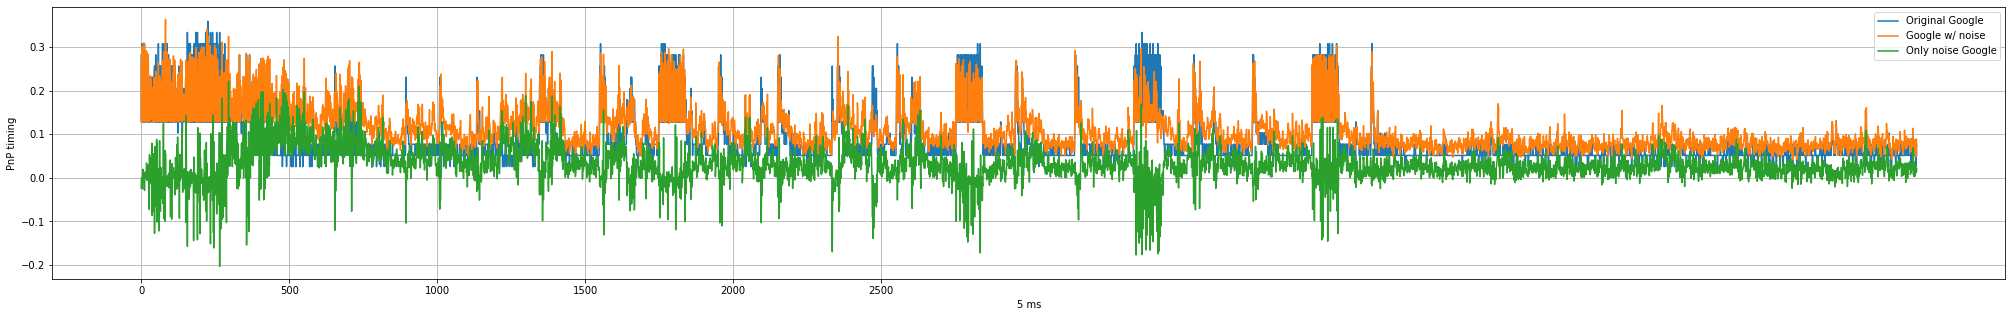

In [109]:

fig = plt.figure(figsize=(35,5))


plt.plot(trainX_test[3602],label='Original Google')
plt.plot(generated_x_noise[3602],label='Google w/ noise')
plt.plot(generated_x_noise[3602]-trainX_test[3602],label='Only noise Google')



plt.legend()
plt.xticks(np.arange(0, 3000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")

fig.savefig('OnlyNoiseGoogle.jpeg')


In [111]:
#only_x_noise_save = np.squeeze(only_x_noise)
#print(only_x_noise_save.shape)

In [112]:
'''
prediction_only_noise = np.argmax(classification_model.predict(only_x_noise_save), axis=1)

print(prediction_only_noise.shape)
print(prediction_only_noise[0:1000])
'''

'\nprediction_only_noise = np.argmax(classification_model.predict(only_x_noise_save), axis=1)\n\nprint(prediction_only_noise.shape)\nprint(prediction_only_noise[0:1000])\n'

In [113]:
'''
score = classification_model.evaluate(only_x_noise_save, trainY_ca, verbose=0)
print(" loss:", score[0])
print("accuracy:", score[1])
print(score)
#print("accuracy:", score[1])
'''

'\nscore = classification_model.evaluate(only_x_noise_save, trainY_ca, verbose=0)\nprint(" loss:", score[0])\nprint("accuracy:", score[1])\nprint(score)\n#print("accuracy:", score[1])\n'

# Only Noise for Each Website Comparison

In [114]:
new_z_noise_each = Lambda(sampling)([dist_each_noise, z_log_var])
#new_z = Lambda(sampling)([z_mean, z_log_var])
#print(new_z)
np.array(new_z_noise_each)

print(type(new_z_noise_each))

NameError: name 'dist_each_noise' is not defined

In [ ]:
only_x_noise_each = vae.decoder.predict(new_z_noise_each)
print(only_x_noise_each.shape)
#print(reconstructed_x[0,:].shape)


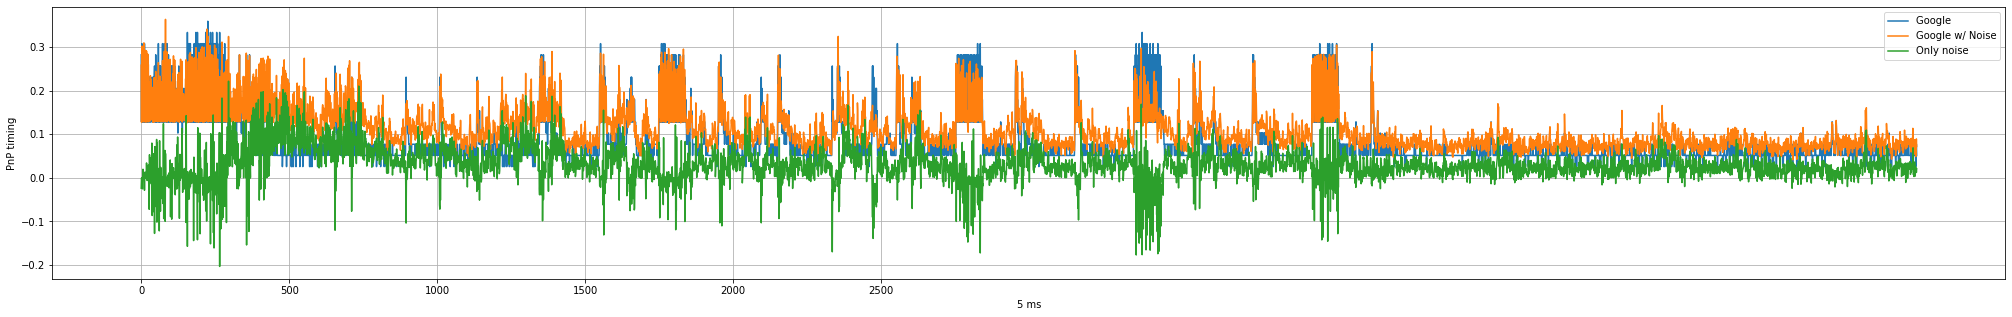

In [116]:

fig = plt.figure(figsize=(35,5))
#plt.plot(trainX_test[0],label='Google')
#plt.plot(trainX_test[2],label='Google')
#plt.plot(trainX_test[1],label='Amazon')

#plt.plot(trainX_test[3800],label='Google')
#plt.plot(generated_x_noise[3800],label='google with noise')
#plt.plot(only_x_noise[3800],label='Only noise')
#plt.plot(only_x_noise_each[3800],label='Only noise each')

#plt.plot(trainX_test[200],label='9gag')
#plt.plot(trainX_test[300],label='9gag')

num = 3602
#plt.plot(generated_x_noise[200],label='9gag with noise')
plt.plot(trainX_test[num],label='Google ')
plt.plot(generated_x_noise[num],label='Google w/ Noise')
plt.plot(generated_x_noise[num]-trainX_test[num],label='Only noise')

ratio=((generated_x_noise[num]-trainX_test[num]) - trainX_test[num])
ratio_minus = np.where(ratio<0,0,ratio)
#plt.plot(ratio_minus,label='ratio')
#print(ratio_minus[0:100])

#plt.plot(only_x_noise_each[0],label='Only noise 9gag')
#plt.plot(only_x_noise_each[400],label='Only noise 2')
#plt.plot(only_x_noise_each[0],label='Only noise 0')
#plt.plot(only_x_noise_each[100],label='Only noise 1')
#plt.plot(only_x_noise_each[700],label='Only noise 3')


plt.legend()
#plt.yticks(np.arange(0, 1, 1))
plt.xticks(np.arange(0, 3000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)

#fig.savefig('OnlyNoiseGoogle.jpeg')
plt.show()

In [117]:
only_x_noise_each_save = np.squeeze(only_x_noise_each)
print(only_x_noise_each_save.shape)

NameError: name 'only_x_noise_each' is not defined

In [118]:
prediction_only_noise_each = np.argmax(classification_model.predict(only_x_noise_each_save), axis=1)

print(prediction_only_noise_each.shape)
print(prediction_only_noise_each[0:1000])

NameError: name 'only_x_noise_each_save' is not defined

In [119]:
score = classification_model.evaluate(only_x_noise_each_save, trainY_ca, verbose=0)
print(" loss:", score[0])
print("accuracy:", score[1])
print(score)
#print("accuracy:", score[1])

NameError: name 'only_x_noise_each_save' is not defined

# Denormalization


In [120]:
trainX_test.shape

(10000, 6000, 1)

In [121]:
denormalized=trainX_test * (maximum-minimum) + minimum

print(denormalized.shape)

(10000, 6000, 1)


Text(0, 0.5, 'PnP timing')

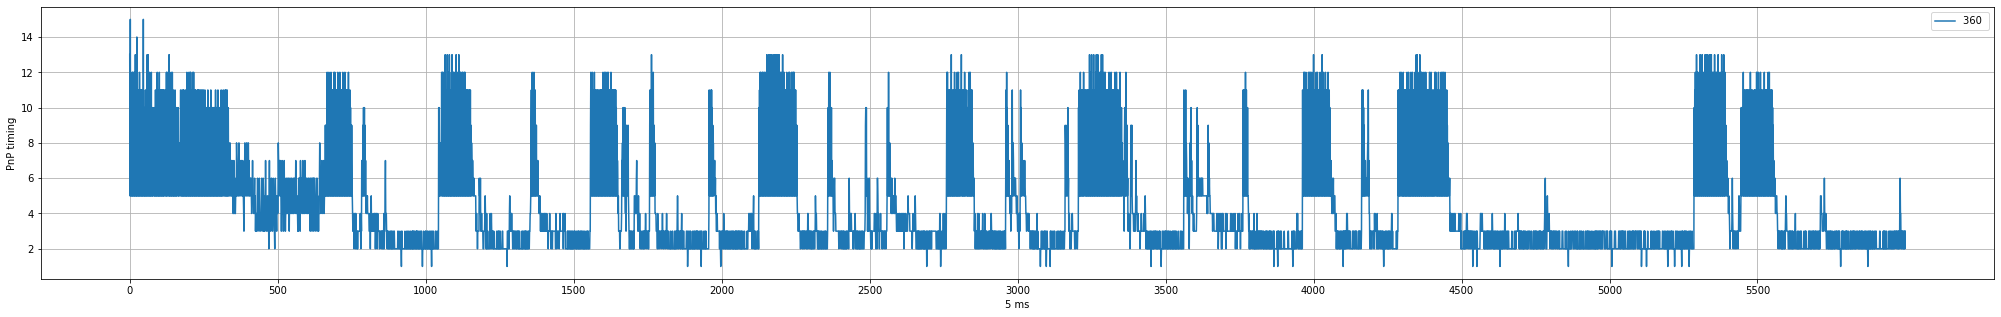

In [122]:

fig = plt.figure(figsize=(35,5))


plt.plot(denormalized[60],label='360 ')



plt.legend()
#plt.yticks(np.arange(0, 1, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)

#fig.savefig('ReconstrucedData2_new.png')
#plt.show()

In [123]:
#tf.keras.layers.

In [124]:
#output_temp=tf.keras.layers.UpSampling1D(size=2)(denormalized)

In [125]:
#print(output_temp.shape)

In [126]:
'''
fig = plt.figure(figsize=(35,5))


plt.plot(output_temp[60],label='360 ')
#plt.plot(trainX[60],label='360 ')


plt.legend()
#plt.yticks(np.arange(0, 1, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)

#fig.savefig('ReconstrucedData2_new.png')
plt.show()
'''

'\nfig = plt.figure(figsize=(35,5))\n\n\nplt.plot(output_temp[60],label=\'360 \')\n#plt.plot(trainX[60],label=\'360 \')\n\n\nplt.legend()\n#plt.yticks(np.arange(0, 1, 1))\nplt.xticks(np.arange(0, 6000, 500))\nplt.grid()\n#plt.axhline(linewidth=1, color=\'r\')\nplt.xlabel("5 ms")\nplt.ylabel("PnP timing")\n#figure(figsize=(8, 6), dpi=80)\n\n#fig.savefig(\'ReconstrucedData2_new.png\')\nplt.show()\n'

In [132]:


with open('reconstructed_x_100_6000_Sep28_100D_NewLayer_FF.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(re_generated_x_save)

with open('reconstructed_x_100_6000_With_EachDistance_Sep28_100D_NewLayer_FF.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(generated_x_noise_each_save)

#with open('reconstructed_x_100_6000_With_MeanNoise(Sep5)_200D_T.csv', 'w', newline='') as file:
#    mywriter = csv.writer(file, delimiter=',')
#    mywriter.writerows(generated_x_noise_save)
    
    
#with open('reconstructed_x_100_3000_Only_Noise(Aug28)_100D_minus.csv', 'w', newline='') as file:
#    mywriter = csv.writer(file, delimiter=',')
#    mywriter.writerows(only_x_noise_save)
    
    

In [133]:

with open('reconstructed_x_100_6000_With_EachDistance_Sep28_100D_NewLayer_FF.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(generated_x_noise_each_save)
    
    
#with open('reconstructed_x_100_3000_Only_NoiseEach(Aug30)_100D.csv', 'w', newline='') as file:
#    mywriter = csv.writer(file, delimiter=',')
#    mywriter.writerows(only_x_noise_each_save)